Потренируемся самостоятельно писать многослойный перцептрон для работы с текстами.

Возьмем для этого датасет про юридические тексты. В этом датасете есть описания дел, а в качестве цп - то, что с делами произошло.

In [1]:
!wget https://raw.githubusercontent.com/rsuh-python/mag2022/main/CL/term02/06-Embeddings/legal_text_classification.csv

--2025-01-09 19:48:31--  https://raw.githubusercontent.com/rsuh-python/mag2022/main/CL/term02/06-Embeddings/legal_text_classification.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68202412 (65M) [text/plain]
Saving to: ‘legal_text_classification.csv’

legal_text_classifi 100%[===================>]  65.04M   299MB/s    in 0.2s    

2025-01-09 19:48:34 (299 MB/s) - ‘legal_text_classification.csv’ saved [68202412/68202412]



Для начала напишем бейзлайн - логистическую регрессию. Возьмем в качестве признаков только текст - описание самого дела (case_text). Целевую переменную, очевидно, нужно превратить в чиселки (OHE).

- проверьте данные на пропуски
- проверьте баланс классов - это очень важно!
- используйте TF-IDF
- не забудьте использовать LabelEncoder
- логистической регрессии может понадобиться выставить solver='liblinear'
- если не помните, как работать с несбалансированными датасетами, просмотрите наши конспекты - точно где-то было (на худой конец документация к логрегу)

In [2]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import LabelEncoder

In [3]:
data = pd.read_csv('legal_text_classification.csv')
data.head()

,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...


In [4]:
data = data.drop('case_id', axis=1)

In [5]:
data.shape

(24985, 3)

In [ ]:
print(set(data.case_outcome))

{'distinguished', 'followed', 'related', 'applied', 'referred to', 'approved', 'cited', 'affirmed', 'discussed', 'considered'}


In [5]:
data = data.dropna()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24809 entries, 0 to 24984
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_outcome  24809 non-null  object
 1   case_title    24809 non-null  object
 2   case_text     24809 non-null  object
dtypes: object(3)
memory usage: 775.3+ KB


In [7]:
data.head()

,case_outcome,case_title,case_text
0,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...


In [6]:
le = LabelEncoder()

data['case_outcome_numeric'] = le.fit_transform(data['case_outcome'])

In [7]:
data = data.drop('case_outcome', axis=1)

In [8]:
data.head()

,case_title,case_text,case_outcome_numeric
0,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...,3
1,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...,3
2,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...,3
3,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...,3
4,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...,3


In [9]:
data['case_text_and_title'] = data['case_title'] + data['case_text']

In [10]:
data = data.drop(['case_text', 'case_title'], axis=1)

In [11]:
data.head()

,case_outcome_numeric,case_text_and_title
0,3,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...
1,3,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...
2,3,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...
3,3,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...
4,3,Dr Martens Australia Pty Ltd v Figgins Holding...


In [12]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
import string

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [15]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [16]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [17]:
stop_words = set(stopwords.words('english'))

In [43]:
def process(text):
    '''Эта функция для лемматизации, удаления стоп-слов, ссылок, пунктуации и приведения к нижнему регистру'''
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # удаляем ссылки
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    #return ' '.join(tokens) # обработанный текст
    return tokens # это для word2vec

In [44]:
data['processed_case_text_title'] = data['case_text_and_title'].apply(process)
data.head()

,case_outcome_numeric,case_text_and_title,processed_case_text_title
0,3,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,"[alpine, hardwood, aust, pty, ltd, v, hardy, p..."
1,3,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,"[black, v, lipovac, 1998, fca, 699, 1998, 217,..."
2,3,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,"[colgate, palmolive, co, v, cussons, pty, ltd,..."
3,3,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,"[dais, studio, pty, ltd, v, bullett, creative,..."
4,3,Dr Martens Australia Pty Ltd v Figgins Holding...,"[dr, marten, australia, pty, ltd, v, figgins, ..."


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data.processed_case_text_title, data.case_outcome_numeric)

In [ ]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.96      0.24      0.38        93
           1       0.27      0.28      0.28       589
           2       0.40      0.14      0.21        70
           3       0.68      0.66      0.67      3071
           4       0.24      0.26      0.25       418
           5       0.40      0.20      0.27       467
           6       0.41      0.27      0.32       245
           7       0.30      0.39      0.34       443
           8       0.35      0.53      0.42       735
           9       0.62      0.28      0.38        72

    accuracy                           0.49      6203
   macro avg       0.46      0.32      0.35      6203
weighted avg       0.51      0.49      0.49      6203



In [ ]:
list(vec.vocabulary_.items())[:10] #

[('yazbeck', 54123),
 ('minister', 38013),
 ('for', 29182),
 ('immigration', 32579),
 ('amp', 17653),
 ('multicultural', 38691),
 ('affairs', 16976),
 ('2002', 4949),
 ('fca', 28552),
 ('980', 16111)]

Если все сделали как я, должна получиться средняя f-score в районе 0.5.

Теперь давайте попробуем написать нейронную сетку по аналогии с тетрадкой про твиттер из прошлого семинара.

In [20]:
import numpy as np
from string import punctuation
from collections import Counter
from sklearn.utils import shuffle, class_weight

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim

In [21]:
data.head()

,case_outcome_numeric,case_text_and_title,processed_case_text_title
0,3,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,alpine hardwood aust pty ltd v hardy pty ltd 2...
1,3,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,black v lipovac 1998 fca 699 1998 217 alr 386t...
2,3,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,colgate palmolive co v cussons pty ltd 1993 47...
3,3,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,dais studio pty ltd v bullett creative pty ltd...
4,3,Dr Martens Australia Pty Ltd v Figgins Holding...,dr marten australia pty ltd v figgins holding ...


class_weight - очень полезная для нас штука. Можно вычислить веса классов автоматически с ее помощью:

In [22]:
# первый аргумент - какие веса высчитывать, второй - какие у нас классы, третий - какие их частоты
yweights = class_weight.compute_class_weight('balanced', classes=np.unique(data.case_outcome_numeric), y=data.case_outcome_numeric)

In [ ]:
yweights

array([23.40471698,  1.01759639, 22.9712963 ,  0.20486375,  1.46021189,
        2.4370334 ,  4.11426202,  1.10164298,  0.56862251, 22.15089286])

Заметьте, что возвращает оно np.array.

Нужно написать:

- функцию для предобработки текста, которая получает сырой текст и возвращает список токенов
- создать словарь word2id
- и обратный ему id2word

In [45]:
train_sentences, val_sentences = train_test_split(data, test_size=0.1)

In [46]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [47]:
vocab = Counter()

for text in data['case_text_and_title']:
    vocab.update(preprocess(text))
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 79761


In [48]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 2:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 2 раз:', len(filtered_vocab))

уникальных токенов, втретившихся больше 2 раз: 40629


In [49]:
word2id = {'PAD': 0}

for word in filtered_vocab: # Итерируемся по множеству слов
    word2id[word] = len(word2id) # добавляем нумерацию словам

In [50]:
id2word = {i: word for word, i in word2id.items()}

Лучше это все, конечно, запускать в колабе... не забудьте там выбрать T4 GPU в рантайме

In [28]:
DEVICE = torch.device('cuda') #if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [ ]:
#DEVICE = torch.device('cpu') #if torch.cuda.is_available() else torch.device('cpu')
#DEVICE

device(type='cpu')

In [51]:
MAX_LEN = 0

for text in data.case_text_and_title:
    tokens = preprocess(text)
    MAX_LEN = max(len(tokens), MAX_LEN)
MAX_LEN

22476

In [52]:
X = []

for text in train_sentences.case_text_and_title:
    tokens = preprocess(text)
    ids = torch.LongTensor([word2id[token] for token in tokens if token in word2id])
    X.append(ids)

In [32]:
print(f'tensor shapes before padding: {[t.size() for t in ids]}')

tensor shapes before padding: [torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Size([]), torch.Siz

In [53]:
X = pad_sequence(X, batch_first=True)

X.shape

torch.Size([22328, 22474])

In [54]:
X = X[:, :100] # если хочется обрезать короче

Нужно написать класс для нашего датасета (можно беспощадно копипастить из тетрадки про твиттер)

In [80]:
class LegalDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['processed_case_text_title'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['case_outcome_numeric'].values
        self.device = DEVICE

    def __len__(self): #это обязательный метод, он должен уметь считать длину датасета
        return self.length

    def __getitem__(self, index): #еще один обязательный метод. По индексу возвращает элемент выборки
        #tokens = self.preprocess(self.dataset[index]) # токенизируем
        tokens = self.dataset[index] # токенизируем
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id]) # превращает текст в список цифр
        y = [self.target[index]] # список таргетов - это наши классы
        return ids, y

    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно, # жта функция в принципе нужна для того чтобы работать с последовательностями где длины не совпадают
    # он понадобится для DataLoader во время итерации по батчам
      ids, y = list(zip(*batch)) # здесь разделяем иксы и игреки, зип первые элементы соединяет друг с другом, вторые друг с другом
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      #мы хотим применять BCELoss, он будет брать на вход predicted размера batch_size x 1
      #(так как для каждого семпла модель будет отдавать одно число), target размера batch_size x 1
      y = torch.LongTensor(y).to(self.device) # tuple ([1], [0], [1])  -> Tensor [[1.], [0.], [1.]]
      return padded_ids, y

In [81]:
train_dataset = LegalDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset) # случайные
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=512)  # 1024 было, потом было 512

In [82]:
val_dataset = LegalDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset) # Не случайные
val_iterator = DataLoader(val_dataset, collate_fn=val_dataset.collate_fn, sampler=val_sampler, batch_size=512) # 1024

In [ ]:
batch = next(iter(train_iterator))

In [ ]:
batch

(tensor([[27506,  5932, 32753,  ...,     0,     0,     0],
         [15516, 34028, 18670,  ...,     0,     0,     0],
         [ 5932, 29160,  4728,  ...,     0,     0,     0],
         ...,
         [ 7394, 17451, 32616,  ...,     0,     0,     0],
         [17097, 17097, 32597,  ...,     0,     0,     0],
         [35591,  5569, 27932,  ...,     0,     0,     0]], device='cuda:0'),
 tensor([[8.],
         [3.],
         [1.],
         [7.],
         [3.],
         [1.],
         [7.],
         [1.],
         [3.],
         [1.],
         [3.],
         [1.],
         [3.],
         [7.],
         [4.],
         [7.],
         [3.],
         [3.],
         [3.],
         [7.],
         [3.],
         [3.],
         [8.],
         [3.],
         [3.],
         [1.],
         [3.],
         [3.],
         [5.],
         [3.],
         [3.],
         [3.],
         [3.],
         [3.],
         [6.],
         [3.],
         [7.],
         [3.],
         [4.],
         [3.],
         [8.]

Ну и наконец напишем архитектуру. Модель при инициализации должна принимать размер словаря и эмбеддинга. У нас в датасете 10 классов, поэтому, в отличие от тетрадки про твиттер, нужно использовать Softmax и возвращать вероятности классов. В качестве лосса подойдет кросс-энтропия (я ее уже за вас вписала вместе с весами классов).

In [ ]:
class MLP(nn.Module):

    def __init__(self, vocab_size, embedding_dim):

        super().__init__()
        # указываем в атрибутах класса, какие слои и активации нам понадобятся
        self.embedding = nn.Embedding(vocab_size, embedding_dim) # передаем матрицы с ванхотами
        self.emb2h = nn.Linear(embedding_dim, 50)
        self.act1 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.h2out = nn.Linear(50, 10)
        #self.act2 = nn.Softmax()  потому что потом используем кросс энтропию


    def forward(self, text): #необходимый метод,  в нем указываем, как именно связываются слои/активации между собой
        # batch_size x seq_len
        #ipdb.set_trace()
        embedded = self.embedding(text)   # переводим последовательность индексов в последовательность эмбеддингов
        # batch_size x seq_len x embedding_dim

        mean_emb = torch.mean(embedded, dim=1) # считаем средний эмбеддинг предложения  это тиипа его вектор/ усреднили эмбеддинги слов получили эмбеддинг предложения
        # batch_size x embedding_dim
        hidden = self.emb2h(mean_emb) # пропускаем эмбеддинг через полносвязный слой
        # batch_size x 10
        hidden = self.act1(hidden)
        # batch_size x 10
        hidden = self.dropout(hidden)
        # batch_size x 10
        out = self.h2out(hidden) # возвращаем одно число для каждого семпла
        # batch_size x 1
        #proba = self.act2(out) # пропускаем число через СОФТМАКС
        return out
        # batch_size x 1

In [ ]:
batch, y = next(iter(train_iterator))

Теперь нужно написать трейнлуп (лучше скопипастить откуда-нибудь), инициализировать нашу модель и запустить)

In [ ]:
def train_loop(model, iterator, optimizer, criterion, scheduler=None):
    print('Training...')
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах
    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам № итератор здесь это даталоадер
        optimizer.zero_grad()  #обнуляем градиенты
        preds_proba = model(texts) #прогоняем данные через модель
        ys = ys.long()
        ys = ys.squeeze()
        loss = criterion(preds_proba, ys) #считаем значение функции потерь
        loss.backward() #считаем градиенты
        optimizer.step() #обновляем веса
        epoch_loss += loss.item() #сохраняем значение функции потерь

        if not (i + 1) % 20:
            print(f'Train loss: {epoch_loss/i}')

        if scheduler is not None:
            scheduler.step()

    return epoch_loss / len(iterator)



## Здесь описание

Я кратко опишу, что происходит дальше в ячейках, потому что там после первого эксперимента немного хаотично всё расположено.

MLP и MLP0. Первая модель - там всё скопировала из тетрадки про твиттер просто. В эксперименте MLP0 добавила предобработку текстов в датасете (результат от этого почти не улучшился).

В декабре ещё эксперементировала, модели MLP4, MLP3, MLP2, MLP1. В этой серии я хотела попробовать предобученные word2vec но были проблемы, не хватало памяти, поэтому я попробовала glove, где-то немного меняла архитектуру, это всё несильно помогло, лосс был очень большой всё равно.

MLP5 - здесь я уменьшила размер той модели google news 300, сохранила уменьшенный вариант, попыталась её использовать, но сильно запуталась с размерами, что-то не совпадало, я пыталась как-то выяснить, что именно с чем не совпадает, не смогла найти ошибку. Ещё появилась ошибка RuntimeError: CUDA error: device-side assert triggered Compile with TORCH_USE_CUDA_DSA to enable device-side assertions после которой надо перезапускать ВСЁ вообще заново, это ошибка меня убила, я честно пыталась как-то её избежать разными методами, но из-за того, что я так и не нашла что с чем не совпадает по размеру, она меня преследовала, после этого я совсем отчаялась и стала делать четвёртую домашку...

### Сейчас я вернулась к этой тетрадке

+ model5 = (архитектура MLP5 + w2v)здесь уже не предобученные эмбеддинги, а обученные на наших данных, ещё пробовала с MultiStepLR и без него, результат не отличался от того, что было раньше, на уровне случайной догадки

+ model6 = увеличила дропаут и кол-во нейронов, LeakyReLU вместо ReLU, использовала ReduceLROnPlateau, ничего не поменялось особо

+ model7 = ещё увеличила дропаут, а также разморозила эмбеддинги (надо было раньше)!!! и началось движение какое-то!! но здесь было сильное переобучение

+ model8 = ещё увеличила дропаут, добавила weight_decay, чуть меньше стала переобучаться

+ model9 = дропаут поменьше и попробовала Adadelta оптимайзер, получилось довольно стабильное обучение + небольшое переобучение

+ model10 = дропаут только после первого слоя, меньше нейронов, ReLU после первого слоя, LeakyReLU после второго, побольше скорость обучения, лучший результат был -
epoch 96, train loss = 1.0035383010452443, val loss = 1.757674264907837, val f1 score = 0.3904645076813264!!
правда, с переобучением всё равно

+ model11 - экспериментировала с гиперпараметрами, стало хуже

+ model12 - попробовала AdamW, epoch 48, train loss = 0.07400519168004394, val loss = 3.444092130661011, val f1 score = 0.5057180408598291, очень большое переобучение

+ model13 - немного другие lr и weight_decay, но переобучение гигантское всё равно, я почему-то решила бросить эту затею, и

+ model14 - попробовать Adamax и PolynomialLR одновременно, вообще фигня получилась

+ model15 - вернулась к Adadelta, как-то с ним хорошо получалось прям, lr=0.006, weight_decay=1e-3 + PolynomialLR, здесь, конечно, f1 хуже, чем в model 10, но меньше переобучения, лучший её результат - epoch 94, LR: 0.003732240056991577
epoch 94, train loss = 1.4499074220657349, val loss = 1.889799952507019, val f1 score = 0.3538167686747604

на этом я решила остановиться, можно точно много чего поменять потестить, но пока экспериментировала думала, а вообще реально ли побить наш бейзлайн TF-IDF этими моделями... наверное? но я не побила

мои лучшие модели это model10 и model15 с f1 = 0.39 и 0.35 соответственно


In [31]:
yweights = torch.Tensor(yweights)# надо перевести в тензор

In [ ]:
model = MLP(len(word2id), 100) # 100 это в X.shape второе число
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss(weight=yweights)

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
def evaluate(model, iterator, criterion, scheduler=None):
    print("\nValidating...")
    epoch_loss = 0
    model.eval()
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):
            predictions = model(texts)  # делаем предсказания на тесте
            ys = ys.long()
            ys = ys.squeeze()
            loss = criterion(predictions, ys)   # считаем значения функции ошибки для статистики
            epoch_loss += loss.item()

            if not (i + 1) % 5:
                print(f'Val loss: {epoch_loss/i}')

            if scheduler is not None:
                scheduler.step()

    return epoch_loss / len(iterator) # возвращаем средний лосс по батчам

In [ ]:
losses = []
losses_eval = []

for i in range(50): # 100 ЭПОХ
    print(f'\nstarting Epoch {i}')
    epoch_loss = train_loop(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)

    epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)


starting Epoch 0
Training...
Train loss: 2.4337551844747445

Validating...

starting Epoch 1
Training...
Train loss: 2.421177337044164

Validating...

starting Epoch 2
Training...
Train loss: 2.4224470540096887

Validating...

starting Epoch 3
Training...
Train loss: 2.4165652927599455

Validating...

starting Epoch 4
Training...
Train loss: 2.4153928756713867

Validating...

starting Epoch 5
Training...
Train loss: 2.417242639943173

Validating...

starting Epoch 6
Training...
Train loss: 2.416394873669273

Validating...

starting Epoch 7
Training...
Train loss: 2.418541017331575

Validating...

starting Epoch 8
Training...
Train loss: 2.4162144159015857

Validating...

starting Epoch 9
Training...
Train loss: 2.4176421792883622

Validating...

starting Epoch 10
Training...
Train loss: 2.418220545116224

Validating...

starting Epoch 11
Training...
Train loss: 2.4198469990178157

Validating...

starting Epoch 12
Training...
Train loss: 2.4156847627539384

Validating...

starting Epoc

In [ ]:
losses_eval

[2.3033382097880044,
 2.3027776082356772,
 2.304513931274414,
 2.305210510889689,
 2.3070542017618814,
 2.306814193725586,
 2.3064800103505454,
 2.3066611289978027,
 2.306551138559977,
 2.30588960647583,
 2.30535626411438,
 2.306327740351359,
 2.306795835494995,
 2.3052567640940347,
 2.30588165918986,
 2.3063310782114663,
 2.3067105611165366,
 2.306603193283081,
 2.3056856791178384,
 2.30675999323527,
 2.3059733708699546,
 2.3072734673817954,
 2.306668678919474,
 2.3050604661305747,
 2.305893818537394,
 2.3055147329966226,
 2.305837392807007,
 2.305973688761393,
 2.3059235413869223,
 2.306305408477783,
 2.306783358256022,
 2.3068843682607016,
 2.305307467778524,
 2.305239121119181,
 2.301717678705851,
 2.3061888217926025,
 2.3056995073954263,
 2.3049174149831138,
 2.305739164352417,
 2.305367628733317,
 2.3059282302856445,
 2.306252956390381,
 2.3062428633371987,
 2.3054000536600747,
 2.305476665496826,
 2.3065481980641684,
 2.3052375316619873,
 2.305712938308716,
 2.3052359422047934,


### насколько я понимаю, такой результат при предсказании 10 классов это то же самое, что случайная догадка....

In [ ]:
model0 = MLP(len(word2id), 100) # это в X.shape второе число
optimizer = optim.Adam(model0.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss(weight=yweights)

model = model0.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
# ЗДЕСЬ ВАРИАНТ С БОЛЕЕ PROCESSED ТЕКСТАМИ !!!!!!!!!!11
losses0 = []
losses_eval0 = []

for i in range(50): # 100 ЭПОХ
    print(f'\nstarting Epoch {i}')
    epoch_loss0 = train_loop(model0, train_iterator, optimizer, criterion)
    losses0.append(epoch_loss0)

    epoch_loss_on_test0 = evaluate(model0, val_iterator, criterion)
    losses_eval0.append(epoch_loss_on_test0)


starting Epoch 0
Training...
Train loss: 2.439760208129883
Train loss: 2.3707079031528573

Validating...
Val loss: 2.881735324859619

starting Epoch 1
Training...
Train loss: 2.422863558719033
Train loss: 2.358759018091055

Validating...
Val loss: 2.882758617401123

starting Epoch 2
Training...
Train loss: 2.4178957813664486
Train loss: 2.3548793425926795

Validating...
Val loss: 2.8866421580314636

starting Epoch 3
Training...
Train loss: 2.4165613651275635
Train loss: 2.356126907544258

Validating...
Val loss: 2.8855568766593933

starting Epoch 4
Training...
Train loss: 2.4235141277313232
Train loss: 2.3568107776152782

Validating...
Val loss: 2.8862348794937134

starting Epoch 5
Training...
Train loss: 2.419930470617194
Train loss: 2.356027597036117

Validating...
Val loss: 2.885018765926361

starting Epoch 6
Training...
Train loss: 2.418276159386886
Train loss: 2.354840162472847

Validating...
Val loss: 2.8847804069519043

starting Epoch 7
Training...
Train loss: 2.415881056534616

Скорее всего, вам понадобится учиться очень много эпох, чтобы предсказывать что-нибудь стоящее (эпох 100...), и, вероятнее всего, придется играться с архитектурой, чтобы получить приличное качество. На семинаре на эксперименты времени нет, поэтому добаловаться можно дома - и заодно попробовать подключить эмбеддинги w2v, например.

In [32]:
import random

In [33]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [34]:
set_random_seed(42) # seed LOCKED !!!!!!!!!!!!

In [35]:
import gensim.downloader
from gensim.models import KeyedVectors
from sklearn.decomposition import PCA

In [ ]:
w2v_model = gensim.downloader.load('word2vec-google-news-300') # а может мне не нужна такая большая...


[=-------------------------------------------------] 2.2% 36.7/1662.8MB downloaded

KeyboardInterrupt: 

In [ ]:
w2v_model.vector_size

300

In [ ]:
filtered_embeddings = {word: w2v_model[word] for word in filtered_vocab if word in w2v_model} # здесь беру эмбеддинги только слов которые есть в filtered vocab


In [ ]:
filtered_word2vec = KeyedVectors(vector_size=300) # надо обрезать потому что не хватало памяти на 300
filtered_word2vec.add_vectors(list(filtered_embeddings.keys()), list(filtered_embeddings.values()))

filtered_word2vec.save('filtered_word2vec.kv')

In [ ]:
word_vectors = np.array([filtered_embeddings[word] for word in filtered_embeddings])

In [ ]:
pca = PCA(n_components=100)
reduced_w2v = pca.fit_transform(word_vectors)

In [ ]:
reduced_embeddings = {word: reduced_w2v[i] for i, word in enumerate(filtered_embeddings)}

In [ ]:
reduced_word2vec = KeyedVectors(vector_size=100)

for word, vector in reduced_embeddings.items():
    reduced_word2vec.add_vector(word, vector)

reduced_word2vec.save('reduced_word2vec.kv')

/usr/local/lib/python3.10/dist-packages/gensim/models/keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


In [ ]:
#filtered_word2vec = KeyedVectors.load('reduced_word2vec.kv')
filtered_word2vec = KeyedVectors.load('reduced_word2vec.kv')

In [ ]:
# размеры векторов
embedding_dim = filtered_word2vec.vector_size

In [ ]:
vocab_size = min(len(filtered_word2vec.key_to_index), 79761) # 50k самых популярных слов
embedding_matrix = torch.zeros((vocab_size, embedding_dim)) # матрица эмбеддингов для нашего словаря

for i, (word, idx) in enumerate(filtered_word2vec.key_to_index.items()): # заполняем матрицу эмбеддингов
    if i >= 79761:
        break
    embedding_matrix[idx] = torch.tensor(filtered_word2vec[word])


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
DEVICE = torch.device('cpu')

In [ ]:
embedding_matrix = embedding_matrix.to(DEVICE) #(19134 на 100)

In [ ]:
embedding_matrix

tensor([[-0.6856, -0.0810,  0.1302,  ..., -0.0148,  0.0151,  0.0231],
        [-0.3054, -0.3535,  0.1266,  ..., -0.1596, -0.1987, -0.1817],
        [-0.3508, -0.0604, -0.2320,  ..., -0.4172, -0.1299,  0.3018],
        ...,
        [ 1.8237,  0.2712, -0.0250,  ..., -0.1350,  0.2009, -0.1649],
        [ 0.3312, -0.7506, -0.3998,  ..., -0.0937,  0.0363, -0.1062],
        [-0.3362, -0.5746,  0.0592,  ...,  0.0988,  0.0351, -0.3639]])

In [ ]:
print(torch.isnan(embedding_matrix).any())  # проверка на NaN
print(torch.isinf(embedding_matrix).any())  # проверка на inf

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


In [ ]:
print(f'Embedding matrix size (in MB): {embedding_matrix.element_size() * embedding_matrix.nelement() / 1024**2}')

Embedding matrix size (in MB): 7.299041748046875


In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [ ]:
torch.cuda.empty_cache()

RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
print(f"Used memory: {torch.cuda.memory_allocated() / 1024**2} MB")
print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2} MB")
print(f"Max memory allocated: {torch.cuda.max_memory_allocated() / 1024**2} MB")

Used memory: 163.341796875 MB
Cached memory: 8350.0 MB
Max memory allocated: 8333.7998046875 MB


In [ ]:
from tqdm import tqdm

In [ ]:
# просто захотелось прогресс бар вставить
def train_loop(model, iterator, optimizer, criterion, scheduler=None):
    print('Training...')
    epoch_loss = 0
    model.train()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    progress_bar = tqdm(enumerate(iterator), total=len(iterator), desc="Training", leave=False)

    for i, (texts, ys) in progress_bar:
        texts = texts.to(device)
        ys = ys.long().squeeze().to(device)

        optimizer.zero_grad()

        preds_proba = model(texts)

        #print(f'Outputs shape: {preds_proba.shape}')
        #print(f'Targets shape: {ys.shape}')
        loss = criterion(preds_proba, ys)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()а
        progress_bar.set_postfix({'Train loss': epoch_loss/(i+1)})

        if scheduler is not None:
            scheduler.step()

    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, scheduler=None):
    print('\nValidating...')
    epoch_loss = 0
    model.eval()

    progress_bar = tqdm(enumerate(iterator), total=len(iterator), desc='Validating', leave=False)

    with torch.no_grad():
        for i, (texts, ys) in progress_bar:
            predictions = model(texts)
            ys = ys.long().squeeze()
            loss = criterion(predictions, ys)
            epoch_loss += loss.item()

            progress_bar.set_postfix({'Val loss': epoch_loss/(i+1)})

            if scheduler is not None:
                scheduler.step()

    return epoch_loss / len(iterator)

In [ ]:
num_embeddings = len(filtered_vocab)

In [ ]:
num_embeddings

40629

In [ ]:
num_embeddings = num_embeddings[:, :19134]

TypeError: 'int' object is not subscriptable

In [ ]:
class MLP5(nn.Module):
    def __init__(self, vocab_size, embedding_dim, pretrained_embeddings):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)

        self.emb2h1 = nn.Linear(embedding_dim, 60)  # 128
        self.batchnorm1 = nn.BatchNorm1d(60)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.1)

        self.emb2h2 = nn.Linear(60, 30)  # 128 -> 64
        self.batchnorm2 = nn.BatchNorm1d(30)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.1)

        self.h2out = nn.Linear(30, 10)  # 64 -> 10

    def forward(self, text):
        embedded = self.embedding(text) # переводим последовательность индексов в последовательность эмбеддингов
        #print(f'embedded shape: {embedded.shape}') # У МЕНЯ ГДЕ-ТО НЕ СОВПАДАЛИ РАЗМЕРЫ - ПРОВЕРКА
        mean_emb = torch.mean(embedded, dim=1) # считаем средний эмбеддинг предложения  это типа его вектор/ усреднили эмбеддинги слов получили эмбеддинг предложения
        #print(f'mean_emb shape: {mean_emb.shape}')

        hidden1 = self.emb2h1(mean_emb) # пропускаем эмбеддинг через полносвязный слой
        #print(f'hidden1 shape: {hidden1.shape}')
        hidden1 = self.batchnorm1(hidden1)
        hidden1 = self.act1(hidden1)
        hidden1 = self.dropout1(hidden1)

        hidden2 = self.emb2h2(hidden1)
        #print(f'hidden2: {hidden2.shape}')
        hidden2 = self.batchnorm2(hidden2)
        hidden2 = self.act2(hidden2)
        hidden2 = self.dropout2(hidden2)

        out = self.h2out(hidden2) # возвращаем одно число для каждого семпла
        #print(f'out shape: {out.shape}')
        return out

In [ ]:
model5 = MLP5(len(word2id), 100, embedding_matrix)
optimizer = optim.Adam(model5.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=yweights)
#scheduler = MultiStepLR(optimizer, milestones=[10, 20, 30, 40], gamma=0.1)

model5 = model5.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
losses5 = []
losses_eval5 = []

for i in range(50): # 50 ЭПОХ
    print(f'\nstarting Epoch {i}')
    epoch_loss5 = train_loop(model5, train_iterator, optimizer, criterion)
    losses5.append(epoch_loss5)

    epoch_loss_on_test5 = evaluate(model5, val_iterator, criterion)
    losses_eval5.append(epoch_loss_on_test5)


starting Epoch 0
Training...


Training:   2%|▏         | 1/44 [00:00<00:09,  4.66it/s]

Index error encountered in batch 0: index out of range in self


Training:   5%|▍         | 2/44 [00:00<00:16,  2.61it/s]

Index error encountered in batch 1: index out of range in self


Training:   7%|▋         | 3/44 [00:01<00:17,  2.30it/s]

Index error encountered in batch 2: index out of range in self


Training:   9%|▉         | 4/44 [00:01<00:16,  2.36it/s]

Index error encountered in batch 3: index out of range in self


Training:  11%|█▏        | 5/44 [00:02<00:18,  2.06it/s]

Index error encountered in batch 4: index out of range in self


Training:  14%|█▎        | 6/44 [00:02<00:17,  2.19it/s]

Index error encountered in batch 5: index out of range in self


Training:  16%|█▌        | 7/44 [00:03<00:18,  1.98it/s]

Index error encountered in batch 6: index out of range in self


Training:  18%|█▊        | 8/44 [00:03<00:18,  1.99it/s]

Index error encountered in batch 7: index out of range in self


Training:  20%|██        | 9/44 [00:04<00:16,  2.13it/s]

Index error encountered in batch 8: index out of range in self


Training:  23%|██▎       | 10/44 [00:04<00:14,  2.39it/s]

Index error encountered in batch 9: index out of range in self


Training:  25%|██▌       | 11/44 [00:05<00:15,  2.12it/s]

Index error encountered in batch 10: index out of range in self


Training:  27%|██▋       | 12/44 [00:05<00:14,  2.21it/s]

Index error encountered in batch 11: index out of range in self


Training:  30%|██▉       | 13/44 [00:06<00:15,  2.01it/s]

Index error encountered in batch 12: index out of range in self


Training:  32%|███▏      | 14/44 [00:06<00:14,  2.01it/s]

Index error encountered in batch 13: index out of range in self


Training:  34%|███▍      | 15/44 [00:07<00:15,  1.89it/s]

Index error encountered in batch 14: index out of range in self


Training:  36%|███▋      | 16/44 [00:07<00:12,  2.18it/s]

Index error encountered in batch 15: index out of range in self


Training:  39%|███▊      | 17/44 [00:07<00:12,  2.12it/s]

Index error encountered in batch 16: index out of range in self


Training:  41%|████      | 18/44 [00:08<00:13,  1.97it/s]

Index error encountered in batch 17: index out of range in self


Training:  43%|████▎     | 19/44 [00:09<00:12,  1.97it/s]

Index error encountered in batch 18: index out of range in self


Training:  45%|████▌     | 20/44 [00:09<00:12,  1.98it/s]

Index error encountered in batch 19: index out of range in self


Training:  48%|████▊     | 21/44 [00:10<00:12,  1.87it/s]

Index error encountered in batch 20: index out of range in self


Training:  50%|█████     | 22/44 [00:10<00:10,  2.16it/s]

Index error encountered in batch 21: index out of range in self


Training:  52%|█████▏    | 23/44 [00:11<00:10,  1.99it/s]

Index error encountered in batch 22: index out of range in self


Training:  55%|█████▍    | 24/44 [00:11<00:08,  2.26it/s]

Index error encountered in batch 23: index out of range in self


Training:  57%|█████▋    | 25/44 [00:11<00:08,  2.33it/s]

Index error encountered in batch 24: index out of range in self


Training:  59%|█████▉    | 26/44 [00:12<00:07,  2.56it/s]

Index error encountered in batch 25: index out of range in self


Training:  61%|██████▏   | 27/44 [00:12<00:08,  2.07it/s]

Index error encountered in batch 26: index out of range in self


Training:  64%|██████▎   | 28/44 [00:13<00:07,  2.18it/s]

Index error encountered in batch 27: index out of range in self


Training:  66%|██████▌   | 29/44 [00:13<00:07,  2.12it/s]

Index error encountered in batch 28: index out of range in self


Training:  68%|██████▊   | 30/44 [00:14<00:06,  2.08it/s]

Index error encountered in batch 29: index out of range in self


Training:  70%|███████   | 31/44 [00:14<00:06,  1.94it/s]

Index error encountered in batch 30: index out of range in self


Training:  73%|███████▎  | 32/44 [00:15<00:06,  1.96it/s]

Index error encountered in batch 31: index out of range in self


Training:  75%|███████▌  | 33/44 [00:15<00:05,  1.86it/s]

Index error encountered in batch 32: index out of range in self


Training:  77%|███████▋  | 34/44 [00:16<00:04,  2.01it/s]

Index error encountered in batch 33: index out of range in self


Training:  80%|███████▉  | 35/44 [00:16<00:04,  2.01it/s]

Index error encountered in batch 34: index out of range in self


Training:  82%|████████▏ | 36/44 [00:17<00:03,  2.28it/s]

Index error encountered in batch 35: index out of range in self


Training:  84%|████████▍ | 37/44 [00:17<00:02,  2.34it/s]

Index error encountered in batch 36: index out of range in self


Training:  86%|████████▋ | 38/44 [00:17<00:02,  2.58it/s]

Index error encountered in batch 37: index out of range in self


Training:  89%|████████▊ | 39/44 [00:18<00:02,  2.21it/s]

Index error encountered in batch 38: index out of range in self


Training:  91%|█████████ | 40/44 [00:18<00:01,  2.15it/s]

Index error encountered in batch 39: index out of range in self


Training:  93%|█████████▎| 41/44 [00:19<00:01,  1.98it/s]

Index error encountered in batch 40: index out of range in self


Training:  95%|█████████▌| 42/44 [00:19<00:00,  2.11it/s]

Index error encountered in batch 41: index out of range in self


Training:  98%|█████████▊| 43/44 [00:20<00:00,  1.96it/s]

Index error encountered in batch 42: index out of range in self


Index error encountered in batch 43: index out of range in self

Validating...


IndexError: index out of range in self

RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

ЭТА ОШИБКА НЕ ДАЁТ МНЕ ПОКОЯ!!!!!!!!!!!!

clamped_value = torch.clamp(value, min=self.low, max=self.high)
cdf_result = dist.cdf(clamped_value)

In [ ]:
plot([('MLP5, reduced w2v google news, embeddings are not frozen, Adam, lr = 0.001, train', losses5)])

In [ ]:
plot([('MLP5, reduced w2v google news, embeddings are not frozen, Adam, lr = 0.001, eval', losses_eval5)])

In [ ]:
class MLP1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, pretrained_embeddings):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)

        self.emb2h1 = nn.Linear(embedding_dim, 128)  # 128
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)

        self.emb2h2 = nn.Linear(128, 64)  # 128 -> 64
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)

        self.h2out = nn.Linear(64, 10)  # 64 -> 10

    def forward(self, text):
        embedded = self.embedding(text) # переводим последовательность индексов в последовательность эмбеддингов
        #print(f'embedded shape: {embedded.shape}') # У МЕНЯ ГДЕ-ТО НЕ СОВПАДАЛИ РАЗМЕРЫ - ПРОВЕРКА
        mean_emb = torch.mean(embedded, dim=1) # считаем средний эмбеддинг предложения  это типа его вектор/ усреднили эмбеддинги слов получили эмбеддинг предложения
        #print(f'mean_emb shape: {mean_emb.shape}')

        hidden1 = self.emb2h1(mean_emb) # пропускаем эмбеддинг через полносвязный слой
        #print(f'hidden1 shape: {hidden1.shape}')
        hidden1 = self.act1(hidden1)
        hidden1 = self.dropout1(hidden1)

        hidden2 = self.emb2h2(hidden1)
        #print(f'hidden2: {hidden2.shape}')
        hidden2 = self.act2(hidden2)
        hidden2 = self.dropout2(hidden2)

        out = self.h2out(hidden2) # возвращаем одно число для каждого семпла
        #print(f'out shape: {out.shape}')
        return out

In [ ]:
model1 = MLP1(len(word2id), 10, embedding_matrix)
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss(weight=yweights)

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

NameError: name 'embedding_matrix' is not defined

In [ ]:
embedding_matrix = embedding_matrix.to(DEVICE)

In [ ]:
losses1 = []
losses_eval1 = []

for i in range(100): # 100 ЭПОХ
    print(f'\nstarting Epoch {i}')
    epoch_loss1 = train_loop(model1, train_iterator, optimizer, criterion)
    losses1.append(epoch_loss1)

    epoch_loss_on_test1 = evaluate(model1, val_iterator, criterion)
    losses_eval1.append(epoch_loss_on_test1)


starting Epoch 0
Training...


OutOfMemoryError: CUDA out of memory. Tried to allocate 22.75 GiB. GPU 0 has a total capacity of 14.75 GiB of which 13.20 GiB is free. Process 4141 has 1.55 GiB memory in use. Of the allocated memory 761.16 MiB is allocated by PyTorch, and 688.84 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
torch.cuda.empty_cache()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
import os


In [ ]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

## Короче кончилась память

In [ ]:
glove_model = gensim.downloader.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
# размеры векторов
embedding_dim = glove_model.vector_size

In [ ]:
# матрица эмбеддингов для нашего словаря
vocab_size = len(glove_model.key_to_index)  # размер словаря
embedding_matrix = torch.zeros((vocab_size, embedding_dim))

# заполняем матрицу эмбеддингов
for word, idx in glove_model.key_to_index.items():
    embedding_matrix[idx] = torch.tensor(glove_model[word])

In [ ]:
embedding_matrix = embedding_matrix.to(DEVICE)

In [ ]:
class MLP2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, pretrained_embeddings):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)

        self.emb2h1 = nn.Linear(embedding_dim, 128)  # 128
        self.act1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(p=0.1)

        self.emb2h2 = nn.Linear(128, 64)  # 128 -> 64
        self.act2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(p=0.1)

        self.h2out = nn.Linear(64, 10)  # 64 -> 10

    def forward(self, text):
        embedded = self.embedding(text) # переводим последовательность индексов в последовательность эмбеддингов
        #print(f'embedded shape: {embedded.shape}') # У МЕНЯ ГДЕ-ТО НЕ СОВПАДАЛИ РАЗМЕРЫ - ПРОВЕРКА
        mean_emb = torch.mean(embedded, dim=1) # считаем средний эмбеддинг предложения  это типа его вектор/ усреднили эмбеддинги слов получили эмбеддинг предложения
        #print(f'mean_emb shape: {mean_emb.shape}')

        hidden1 = self.emb2h1(mean_emb) # пропускаем эмбеддинг через полносвязный слой
        #print(f'hidden1 shape: {hidden1.shape}')
        hidden1 = self.act1(hidden1)
        hidden1 = self.dropout1(hidden1)

        hidden2 = self.emb2h2(hidden1)
        #print(f'hidden2: {hidden2.shape}')
        hidden2 = self.act2(hidden2)
        hidden2 = self.dropout2(hidden2)

        out = self.h2out(hidden2) # возвращаем одно число для каждого семпла
        #print(f'out shape: {out.shape}')
        return out

In [ ]:
model2 = MLP2(len(word2id), 25, embedding_matrix)
optimizer = optim.Adam(model2.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss(weight=yweights)

model2 = model2.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
losses2 = []
losses_eval2 = []

for i in range(50): # 50 ЭПОХ
    print(f'\nstarting Epoch {i}')
    epoch_loss2 = train_loop(model2, train_iterator, optimizer, criterion)
    losses2.append(epoch_loss2)

    epoch_loss_on_test2 = evaluate(model2, val_iterator, criterion)
    losses_eval2.append(epoch_loss_on_test2)


starting Epoch 0
Training...
Train loss: 2.431846970006039

Validating...

starting Epoch 1
Training...
Train loss: 2.4257446464739347

Validating...

starting Epoch 2
Training...
Train loss: 2.4218420731393913

Validating...

starting Epoch 3
Training...
Train loss: 2.418893236862986

Validating...

starting Epoch 4
Training...
Train loss: 2.4207092711800025

Validating...

starting Epoch 5
Training...
Train loss: 2.4193246741043892

Validating...

starting Epoch 6
Training...
Train loss: 2.41600365387766

Validating...

starting Epoch 7
Training...
Train loss: 2.417494585639552

Validating...

starting Epoch 8
Training...
Train loss: 2.4172526660718416

Validating...

starting Epoch 9
Training...
Train loss: 2.4138858694779244

Validating...

starting Epoch 10
Training...
Train loss: 2.4171145087794255

Validating...

starting Epoch 11
Training...
Train loss: 2.415608945645784

Validating...

starting Epoch 12
Training...
Train loss: 2.4156024330540706

Validating...

starting Epoch

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot(histories):
    plt.figure(figsize=(16,10))

    for name, val_loss in histories:
        plt.plot(val_loss, label=name)

    plt.legend()

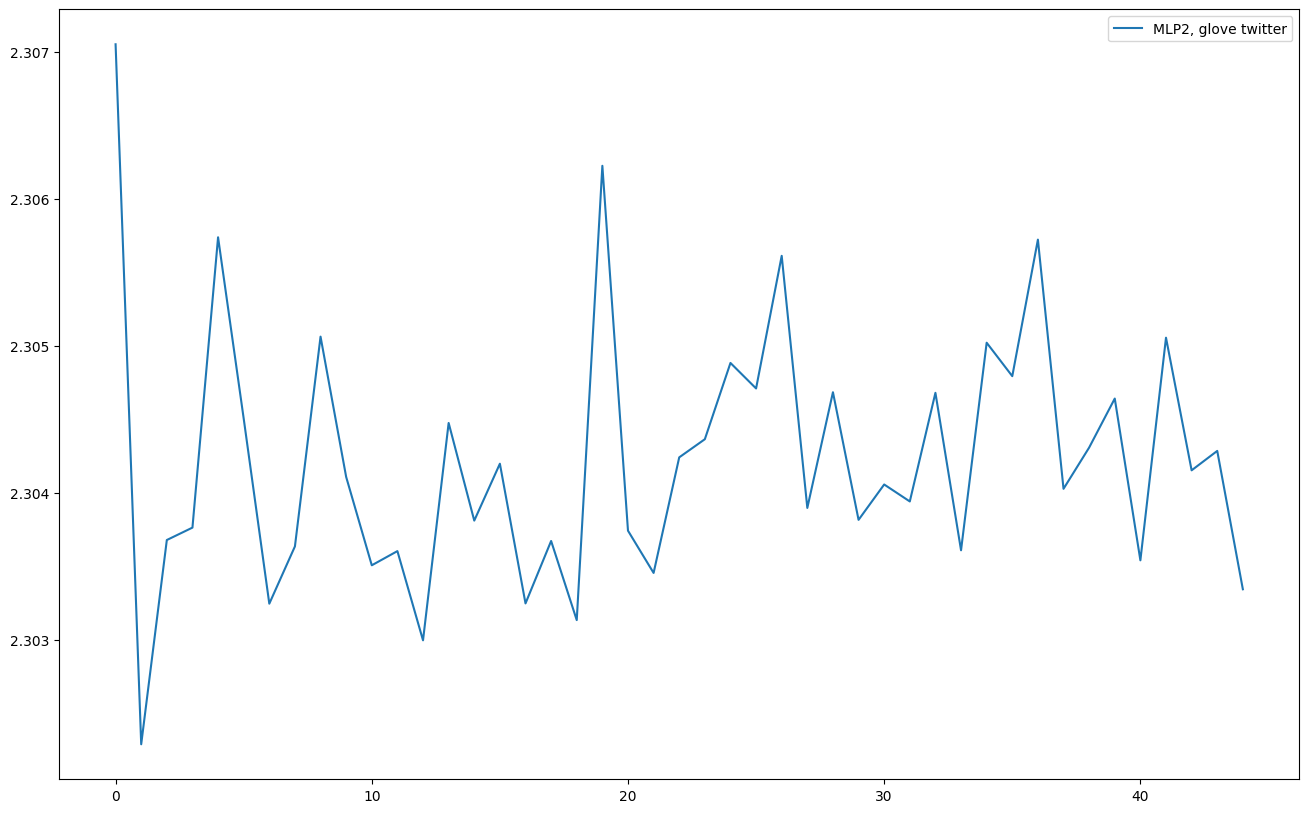

In [ ]:
plot([('MLP2, glove twitter', losses_eval2)])

лосс растёт :(

In [ ]:
class MLP3(nn.Module):
    def __init__(self, vocab_size, embedding_dim, pretrained_embeddings):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)

        self.emb2h1 = nn.Linear(embedding_dim, 60)  # 128
        self.batchnorm1 = nn.BatchNorm1d(60)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.1)

        self.emb2h2 = nn.Linear(60, 30)  # 128 -> 64
        self.batchnorm2 = nn.BatchNorm1d(30)
        self.act2 = nn.ReLU()
        #self.dropout2 = nn.Dropout(p=0.3)

        self.h2out = nn.Linear(30, 10)  # 64 -> 10

    def forward(self, text):
        embedded = self.embedding(text) # переводим последовательность индексов в последовательность эмбеддингов
        #print(f'embedded shape: {embedded.shape}') # У МЕНЯ ГДЕ-ТО НЕ СОВПАДАЛИ РАЗМЕРЫ - ПРОВЕРКА
        mean_emb = torch.mean(embedded, dim=1) # считаем средний эмбеддинг предложения  это типа его вектор/ усреднили эмбеддинги слов получили эмбеддинг предложения
        #print(f'mean_emb shape: {mean_emb.shape}')

        hidden1 = self.emb2h1(mean_emb) # пропускаем эмбеддинг через полносвязный слой
        #print(f'hidden1 shape: {hidden1.shape}')
        hidden1 = self.batchnorm1(hidden1)
        hidden1 = self.act1(hidden1)
        hidden1 = self.dropout1(hidden1)

        hidden2 = self.emb2h2(hidden1)
        #print(f'hidden2: {hidden2.shape}')
        hidden2 = self.batchnorm2(hidden2)
        hidden2 = self.act2(hidden2)
        #hidden2 = self.dropout2(hidden2)

        out = self.h2out(hidden2) # возвращаем одно число для каждого семпла
        #print(f'out shape: {out.shape}')
        return out

In [ ]:
model3 = MLP3(len(word2id), 25, embedding_matrix)
optimizer = optim.Adam(model3.parameters(), lr=0.01, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(weight=yweights)

model3 = model3.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
losses3 = []
losses_eval3 = []

for i in range(50): # 50 ЭПОХ
    print(f'\nstarting Epoch {i}')
    epoch_loss3 = train_loop(model3, train_iterator, optimizer, criterion)
    losses3.append(epoch_loss3)

    epoch_loss_on_test3 = evaluate(model3, val_iterator, criterion)
    losses_eval3.append(epoch_loss_on_test3)


starting Epoch 0
Training...
Train loss: 2.4220644549319617

Validating...

starting Epoch 1
Training...
Train loss: 2.379135244771054

Validating...

starting Epoch 2
Training...
Train loss: 2.36300075681586

Validating...

starting Epoch 3
Training...
Train loss: 2.368907752789949

Validating...

starting Epoch 4
Training...
Train loss: 2.352590096624274

Validating...

starting Epoch 5
Training...
Train loss: 2.3340459497351396

Validating...

starting Epoch 6
Training...
Train loss: 2.3116198715410734

Validating...

starting Epoch 7
Training...
Train loss: 2.307654255314877

Validating...

starting Epoch 8
Training...
Train loss: 2.3177992795643054

Validating...

starting Epoch 9
Training...
Train loss: 2.3178583697268835

Validating...

starting Epoch 10
Training...
Train loss: 2.288555044876902

Validating...

starting Epoch 11
Training...
Train loss: 2.3094466234508313

Validating...

starting Epoch 12
Training...
Train loss: 2.3047519608547815

Validating...

starting Epoch 

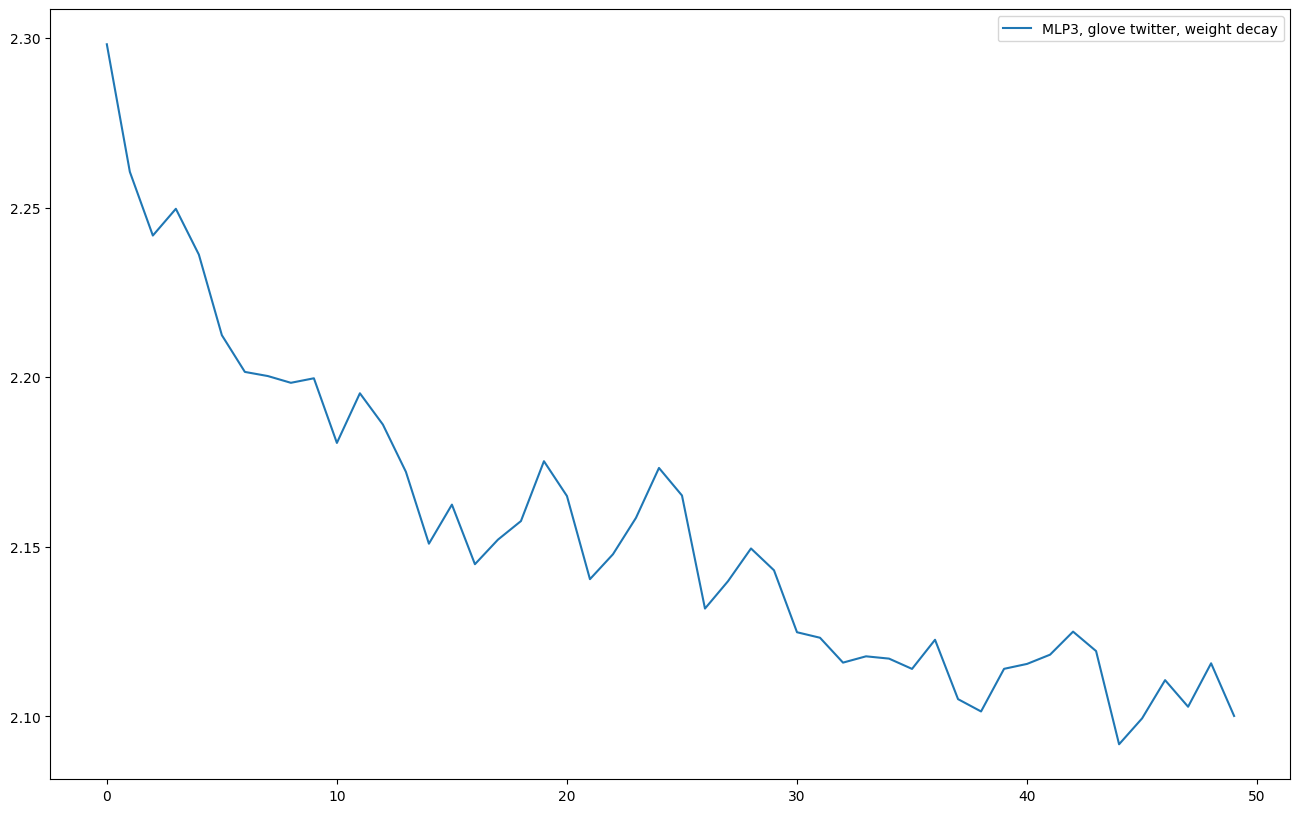

In [ ]:
plot([('MLP3, glove twitter, weight decay', losses3)])

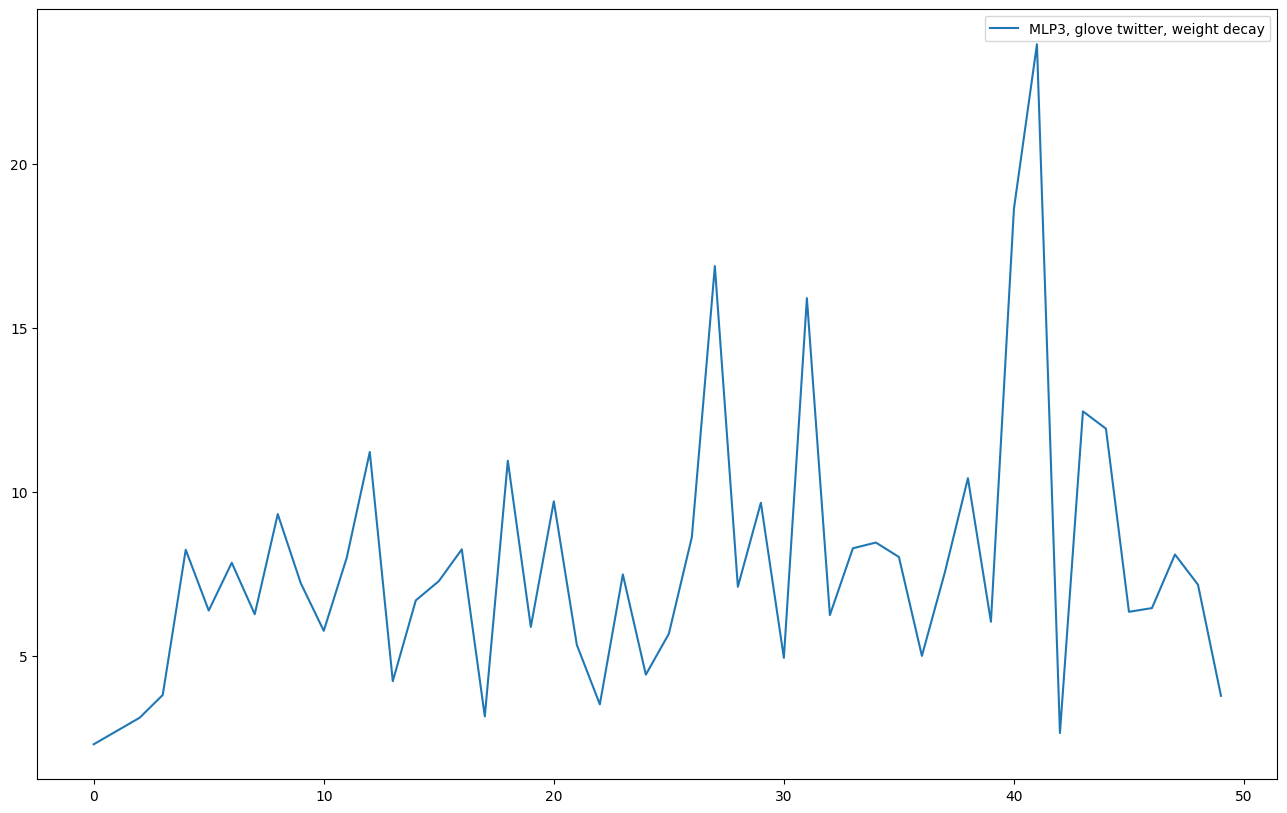

In [ ]:
plot([('MLP3, glove twitter, weight decay', losses_eval3)])

## next

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR
import tqdm

In [ ]:
class MLP4(nn.Module):
    def __init__(self, vocab_size, embedding_dim, pretrained_embeddings):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)

        self.emb2h1 = nn.Linear(embedding_dim, 60)  # 128
        self.batchnorm1 = nn.BatchNorm1d(60)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.3)

        self.emb2h2 = nn.Linear(60, 30)  # 128 -> 64
        self.batchnorm2 = nn.BatchNorm1d(30)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.3)

        self.h2out = nn.Linear(30, 10)  # 64 -> 10

    def forward(self, text):
        embedded = self.embedding(text) # переводим последовательность индексов в последовательность эмбеддингов
        #print(f'embedded shape: {embedded.shape}') # У МЕНЯ ГДЕ-ТО НЕ СОВПАДАЛИ РАЗМЕРЫ - ПРОВЕРКА
        mean_emb = torch.mean(embedded, dim=1) # считаем средний эмбеддинг предложения  это типа его вектор/ усреднили эмбеддинги слов получили эмбеддинг предложения
        #print(f'mean_emb shape: {mean_emb.shape}')

        hidden1 = self.emb2h1(mean_emb) # пропускаем эмбеддинг через полносвязный слой
        #print(f'hidden1 shape: {hidden1.shape}')
        hidden1 = self.batchnorm1(hidden1)
        hidden1 = self.act1(hidden1)
        hidden1 = self.dropout1(hidden1)

        hidden2 = self.emb2h2(hidden1)
        #print(f'hidden2: {hidden2.shape}')
        hidden2 = self.batchnorm2(hidden2)
        hidden2 = self.act2(hidden2)
        hidden2 = self.dropout2(hidden2)

        out = self.h2out(hidden2) # возвращаем одно число для каждого семпла
        #print(f'out shape: {out.shape}')
        return out

In [ ]:
model4 = MLP4(len(word2id), 25, embedding_matrix)
optimizer = optim.Adam(model4.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss(weight=yweights)
scheduler = MultiStepLR(optimizer, milestones=[10, 20, 30, 40], gamma=0.1)

model4 = model4.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
losses4 = []
losses_eval4 = []

for i in range(50): # 50 ЭПОХ
    print(f'\nstarting Epoch {i}')
    epoch_loss4 = train_loop(model4, train_iterator, optimizer, criterion, scheduler)
    losses4.append(epoch_loss4)

    epoch_loss_on_test4 = evaluate(model4, val_iterator, criterion, scheduler)
    losses_eval4.append(epoch_loss_on_test4)


starting Epoch 0
Training...
Train loss: 2.419605619028995

Validating...

starting Epoch 1
Training...
Train loss: 2.4047555170561137

Validating...

starting Epoch 2
Training...
Train loss: 2.4103294171785055

Validating...

starting Epoch 3
Training...
Train loss: 2.4073687101665295

Validating...

starting Epoch 4
Training...
Train loss: 2.4065917918556616

Validating...

starting Epoch 5
Training...
Train loss: 2.4103379375056218

Validating...

starting Epoch 6
Training...
Train loss: 2.4082823552583394

Validating...

starting Epoch 7
Training...
Train loss: 2.407342659799676

Validating...

starting Epoch 8
Training...
Train loss: 2.408414865794935

Validating...

starting Epoch 9
Training...
Train loss: 2.4089915877894352

Validating...

starting Epoch 10
Training...
Train loss: 2.412848660820409

Validating...

starting Epoch 11
Training...
Train loss: 2.41095222924885

Validating...

starting Epoch 12
Training...
Train loss: 2.413827996504934

Validating...

starting Epoch 

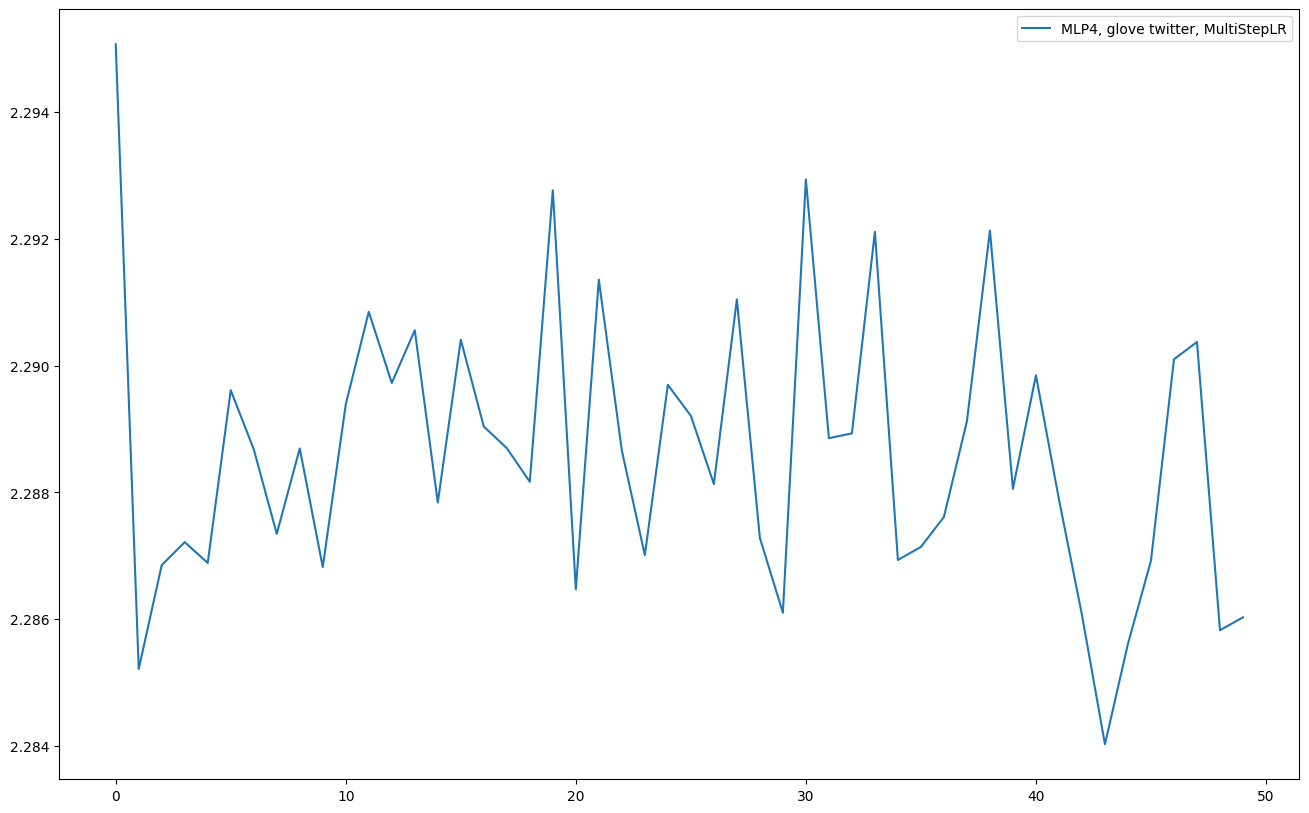

In [ ]:
plot([('MLP4, glove twitter, MultiStepLR', losses4)])

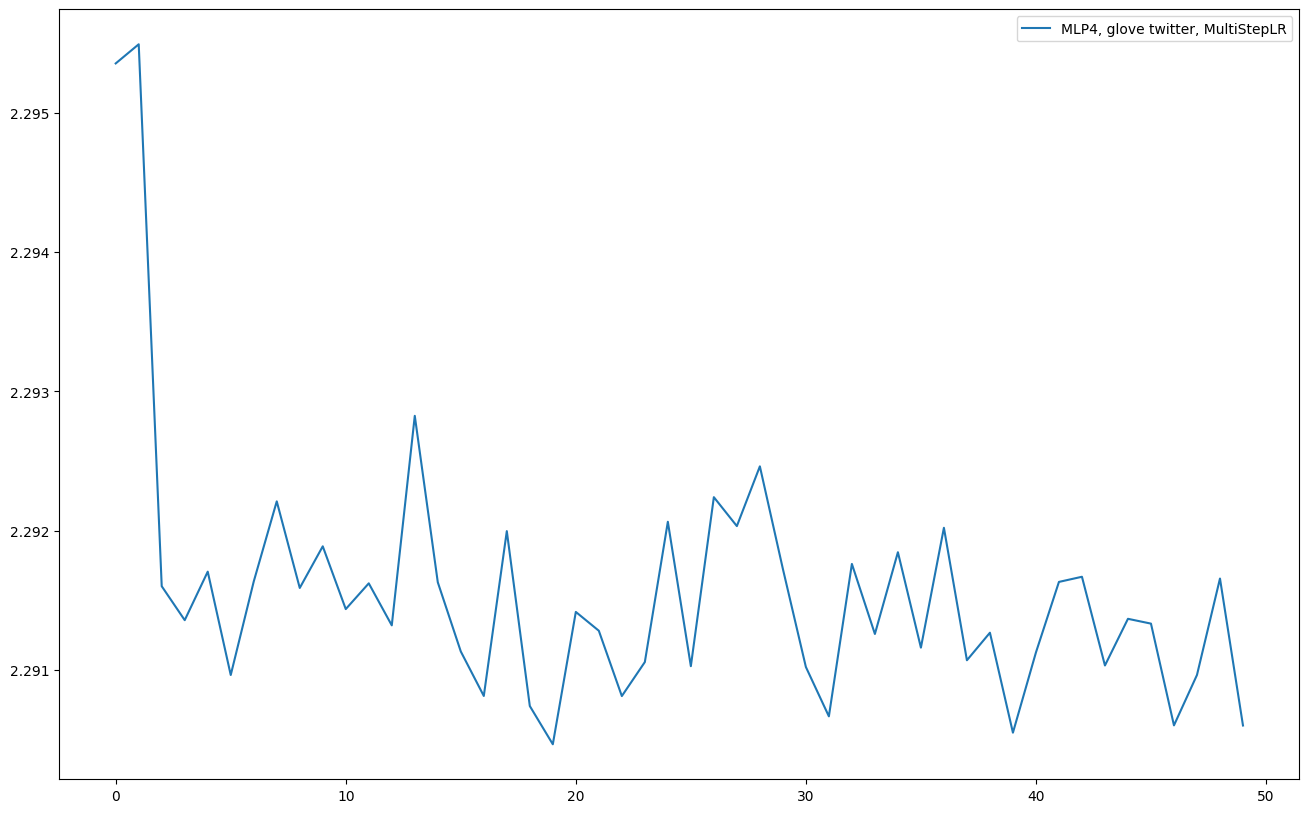

In [ ]:
plot([('MLP4, glove twitter, MultiStepLR', losses_eval4)])

## всё сначала


In [63]:
import gensim
import matplotlib.pyplot as plt

In [64]:
set_random_seed(42)

In [116]:
def train_loop(model, iterator, optimizer, criterion):
    print('training...')
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах
    model.train()
    for i, (texts, ys) in enumerate(iterator):
        texts = texts.to(DEVICE)
        ys = ys.to(DEVICE)
        optimizer.zero_grad()  #обнуляем градиенты
        preds_proba = model(texts) #прогоняем данные через модель
        ys = ys.long()
        ys = ys.squeeze()
        loss = criterion(preds_proba, ys) #считаем значение функции потерь
        loss.backward() #считаем градиенты
        optimizer.step() #обновляем веса
        epoch_loss += loss.item() #сохраняем значение функции потерь
    return epoch_loss/len(iterator)

In [117]:
def evaluate(model, iterator, criterion):
    print('\nvalidating...')
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_true = []
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):
            texts = texts.to(DEVICE) # на всякий случай потому что иногда что-то оказывалось не на гпу
            ys = ys.to(DEVICE)
            predictions = model(texts)
            ys = ys.long()
            ys = ys.squeeze()
            loss = criterion(predictions, ys)
            epoch_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(ys.cpu().numpy())

    f1 = f1_score(all_true, all_preds, average='weighted')
    return epoch_loss/len(iterator), f1

In [118]:
def fullloop(model, train_iterator, val_iterator, optimizer, criterion, num_epochs=50, scheduler=None):
    '''общая функция с трейном, валидацией и графиками'''
    train_losses = []
    val_losses = []
    val_f1all = []

    for epoch in range(num_epochs):
        tr_loss = train_loop(model, train_iterator, optimizer, criterion)
        val_loss, val_f1 = evaluate(model, val_iterator, criterion)

        train_losses.append(tr_loss)
        val_losses.append(val_loss)
        val_f1all.append(val_f1)

        if scheduler is not None:
            scheduler.step(val_loss)
            if epoch % 2 == 0:
                print(f'epoch {epoch}, LR: {scheduler.get_last_lr()[0]}')

        if epoch % 2 == 0:
            print(f'epoch {epoch}, train loss = {tr_loss}, val loss = {val_loss}, val f1 score = {val_f1}')

    plt.figure(figsize=(10,4))
    plt.plot(train_losses, label='train loss')
    plt.plot(val_losses, label='val loss')
    plt.title('loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(val_f1all, label='val F1')
    plt.title('val F1')
    plt.legend()
    plt.show()

In [68]:
texts = data['processed_case_text_title']

In [71]:
w2v = gensim.models.Word2Vec(
    sentences=texts,
    vector_size=100,
    window=5,
    min_count=1,
    max_vocab_size=None
)

In [72]:
embedding_dim = 100
weights = np.zeros((len(word2id), embedding_dim))

In [73]:
for word, i in word2id.items():
    if word == 'PAD':
        continue
        weights[i] = w2v.wv[word]

In [51]:
class MLP5w2v(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(weights, dtype=torch.float32),
            freeze=True,
            padding_idx=0
        )

        self.emb2h1 = nn.Linear(embedding_dim, 60)  # 128
        self.batchnorm1 = nn.BatchNorm1d(60)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.1)

        self.emb2h2 = nn.Linear(60, 30)  # 128 -> 64
        self.batchnorm2 = nn.BatchNorm1d(30)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.1)

        self.h2out = nn.Linear(30, 10)  # 64 -> 10

    def forward(self, text):
        embedded = self.embedding(text) # переводим последовательность индексов в последовательность эмбеддингов
        #print(f'embedded shape: {embedded.shape}') # У МЕНЯ ГДЕ-ТО НЕ СОВПАДАЛИ РАЗМЕРЫ - ПРОВЕРКА
        mean_emb = torch.mean(embedded, dim=1) # считаем средний эмбеддинг предложения  это типа его вектор/ усреднили эмбеддинги слов получили эмбеддинг предложения
        #print(f'mean_emb shape: {mean_emb.shape}')

        hidden1 = self.emb2h1(mean_emb) # пропускаем эмбеддинг через полносвязный слой
        #print(f'hidden1 shape: {hidden1.shape}')
        hidden1 = self.batchnorm1(hidden1)
        hidden1 = self.act1(hidden1)
        hidden1 = self.dropout1(hidden1)

        hidden2 = self.emb2h2(hidden1)
        #print(f'hidden2: {hidden2.shape}')
        hidden2 = self.batchnorm2(hidden2)
        hidden2 = self.act2(hidden2)
        hidden2 = self.dropout2(hidden2)

        out = self.h2out(hidden2) # возвращаем одно число для каждого семпла
        #print(f'out shape: {out.shape}')
        return out

In [61]:
from torch.optim.lr_scheduler import MultiStepLR

In [71]:
model5 = MLP5w2v(len(word2id), 100)
optimizer = optim.Adam(model5.parameters(), lr=0.001, weight_decay=0.001)
criterion = nn.CrossEntropyLoss(weight=yweights)
#schedulermulti = MultiStepLR(optimizer, milestones=[10, 20, 30, 40, 50, 60, 70, 80, 90], gamma=0.1)

model5 = model5.to(DEVICE)
criterion = criterion.to(DEVICE)

In [72]:
fullloop(model5, train_iterator, val_iterator, optimizer, criterion, num_epochs=100) # scheduler=schedulermulti

training...

validating...
epoch 0, train loss = 2.3091982440514998, val loss = 2.3041462898254395, val f1 score = 4.656326711163689e-05
training...

validating...
training...

validating...
epoch 2, train loss = 2.3070797486738726, val loss = 11.41660270690918, val f1 score = 0.32463709606297975
training...

validating...
training...

validating...
epoch 4, train loss = 2.3042402971874583, val loss = 2.9814505577087402, val f1 score = 0.015339326294907769
training...

validating...
training...

validating...
epoch 6, train loss = 2.3036098859526892, val loss = 2.32715744972229, val f1 score = 0.015339326294907769
training...

validating...
training...

validating...
epoch 8, train loss = 2.302431117404591, val loss = 2.865957832336426, val f1 score = 0.015339326294907769
training...

validating...
training...

validating...
epoch 10, train loss = 2.3022926070473413, val loss = 2.4793612480163576, val f1 score = 4.656326711163689e-05
training...

validating...
training...

validating..

NameError: name 'plt' is not defined

## другая модель

In [74]:
class MLP6w2v(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(weights, dtype=torch.float32),
            freeze=True,
            padding_idx=0
        )

        self.emb2h1 = nn.Linear(embedding_dim, 128)  # 128
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.act1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(p=0.2)

        self.emb2h2 = nn.Linear(128, 64)  # 128 -> 64
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.act2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(p=0.1)

        self.h2out = nn.Linear(64, 10)  # 64 -> 10

    def forward(self, text):
        embedded = self.embedding(text) # переводим последовательность индексов в последовательность эмбеддингов
        #print(f'embedded shape: {embedded.shape}') # У МЕНЯ ГДЕ-ТО НЕ СОВПАДАЛИ РАЗМЕРЫ - ПРОВЕРКА
        mean_emb = torch.mean(embedded, dim=1) # считаем средний эмбеддинг предложения  это типа его вектор/ усреднили эмбеддинги слов получили эмбеддинг предложения
        #print(f'mean_emb shape: {mean_emb.shape}')

        hidden1 = self.emb2h1(mean_emb) # пропускаем эмбеддинг через полносвязный слой
        #print(f'hidden1 shape: {hidden1.shape}')
        hidden1 = self.batchnorm1(hidden1)
        hidden1 = self.act1(hidden1)
        hidden1 = self.dropout1(hidden1)

        hidden2 = self.emb2h2(hidden1)
        #print(f'hidden2: {hidden2.shape}')
        hidden2 = self.batchnorm2(hidden2)
        hidden2 = self.act2(hidden2)
        hidden2 = self.dropout2(hidden2)

        out = self.h2out(hidden2) # возвращаем одно число для каждого семпла
        #print(f'out shape: {out.shape}')
        return out

In [75]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [77]:
model6 = MLP6w2v(len(word2id), 100)
optimizer = optim.Adam(model6.parameters(), lr=0.1, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(weight=yweights)
schedulerplateau = ReduceLROnPlateau(optimizer, 'min')

model6 = model6.to(DEVICE)
criterion = criterion.to(DEVICE)

training...

validating...
epoch 0, LR: 0.1
epoch 0, train loss = 2.318107718771154, val loss = 2.3178036212921143, val f1 score = 5.4625256197299954e-05
training...

validating...
training...

validating...
epoch 2, LR: 0.1
epoch 2, train loss = 2.318585753440857, val loss = 2.3181740283966064, val f1 score = 0.0007650236660278193
training...

validating...
training...

validating...
epoch 4, LR: 0.1
epoch 4, train loss = 2.31606125831604, val loss = 2.300380229949951, val f1 score = 0.0098152952290849
training...

validating...
training...

validating...
epoch 6, LR: 0.1
epoch 6, train loss = 2.3138124996965583, val loss = 2.3029613494873047, val f1 score = 6.332697640343161e-05
training...

validating...
training...

validating...
epoch 8, LR: 0.1
epoch 8, train loss = 2.313756438818845, val loss = 2.3295615673065186, val f1 score = 0.0007650236660278193
training...

validating...
training...

validating...
epoch 10, LR: 0.1
epoch 10, train loss = 2.316957338289781, val loss = 2.306

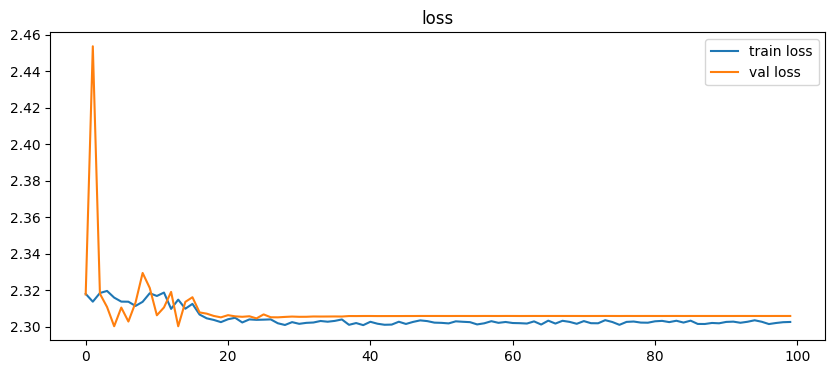

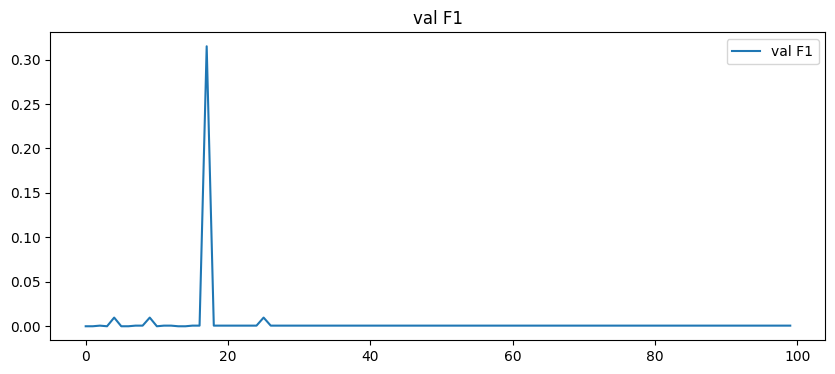

In [84]:
fullloop(model6, train_iterator, val_iterator, optimizer, criterion, num_epochs=100, scheduler=schedulerplateau)

In [85]:
torch.cuda.empty_cache()

In [96]:
class MLP7w2v(nn.Module):
    '''без батчнорма'''
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(weights, dtype=torch.float32),
            freeze=False,
            padding_idx=0
        )

        self.emb2h1 = nn.Linear(embedding_dim, 128)  # 128
        #self.batchnorm1 = nn.BatchNorm1d(128)
        self.act1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(p=0.3)

        self.emb2h2 = nn.Linear(128, 64)  # 128 -> 64
        #self.batchnorm2 = nn.BatchNorm1d(64)
        self.act2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(p=0.1)

        self.h2out = nn.Linear(64, 10)  # 64 -> 10

    def forward(self, text):
        embedded = self.embedding(text)

        mean_emb = torch.mean(embedded, dim=1)


        hidden1 = self.emb2h1(mean_emb)
        #print(f'hidden1 shape: {hidden1.shape}')
        #hidden1 = self.batchnorm1(hidden1)
        hidden1 = self.act1(hidden1)
        hidden1 = self.dropout1(hidden1)

        hidden2 = self.emb2h2(hidden1)

        #hidden2 = self.batchnorm2(hidden2)
        hidden2 = self.act2(hidden2)
        hidden2 = self.dropout2(hidden2)

        out = self.h2out(hidden2) # возвращаем одно число для каждого семпла

        return out

In [97]:
model7 = MLP7w2v(len(word2id), 100)
optimizer = optim.Adam(model7.parameters(), lr=0.005) # weight_decay=1e-5
criterion = nn.CrossEntropyLoss(weight=yweights)
#schedulerplateau = ReduceLROnPlateau(optimizer, 'min')

model7 = model7.to(DEVICE)
criterion = criterion.to(DEVICE)

training...

validating...
epoch 0, train loss = 2.304227688095786, val loss = 2.301055574417114, val f1 score = 0.005238962981638059
training...

validating...
training...

validating...
epoch 2, train loss = 1.9770725261081348, val loss = 1.9828918695449829, val f1 score = 0.3047281360309125
training...

validating...
training...

validating...
epoch 4, train loss = 1.8458876501430164, val loss = 2.0284049987792967, val f1 score = 0.278402264516062
training...

validating...
training...

validating...
epoch 6, train loss = 1.773700787262483, val loss = 1.9032153844833375, val f1 score = 0.09169272969580902
training...

validating...
training...

validating...
epoch 8, train loss = 1.6015803868120366, val loss = 1.9632927179336548, val f1 score = 0.284151067218825
training...

validating...
training...

validating...
epoch 10, train loss = 1.388149158521132, val loss = 2.150769829750061, val f1 score = 0.2548931149440204
training...

validating...
training...

validating...
epoch 12, 

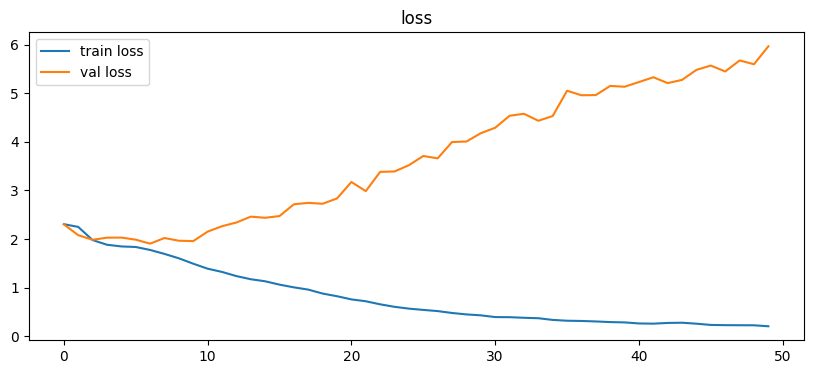

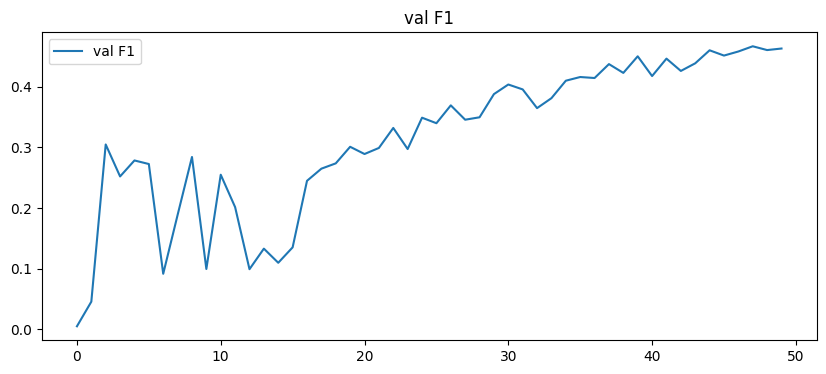

In [98]:
fullloop(model7, train_iterator, val_iterator, optimizer, criterion, num_epochs=50)

переобучение АААААААААААААААААААААААААААААААААААААААААААААААААА

## но я рада, что увидела цифры кроме 2.3 и 2.4......

# другая

In [103]:
class MLP8w2v(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(weights, dtype=torch.float32),
            freeze=False,
            padding_idx=0
        )

        self.emb2h1 = nn.Linear(embedding_dim, 128)  # 128
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.act1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(p=0.5)

        self.emb2h2 = nn.Linear(128, 64)  # 128 -> 64
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.act2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(p=0.5)

        self.h2out = nn.Linear(64, 10)  # 64 -> 10

    def forward(self, text):
        embedded = self.embedding(text)

        mean_emb = torch.mean(embedded, dim=1)

        hidden1 = self.emb2h1(mean_emb)
        hidden1 = self.batchnorm1(hidden1)
        hidden1 = self.act1(hidden1)
        hidden1 = self.dropout1(hidden1)

        hidden2 = self.emb2h2(hidden1)

        hidden2 = self.batchnorm2(hidden2)
        hidden2 = self.act2(hidden2)
        hidden2 = self.dropout2(hidden2)

        out = self.h2out(hidden2) # возвращаем одно число для каждого семпла

        return out

In [104]:
model8 = MLP8w2v(len(word2id), 100)
optimizer = optim.Adam(model8.parameters(), lr=0.005, weight_decay=1e-3) # weight_decay=1e-5
criterion = nn.CrossEntropyLoss(weight=yweights)
#schedulerplateau = ReduceLROnPlateau(optimizer, 'min')

model8 = model8.to(DEVICE)
criterion = criterion.to(DEVICE)

training...

validating...
epoch 0, train loss = 2.2305947758934717, val loss = 2.35175199508667, val f1 score = 0.0031848555606653946
training...

validating...
training...

validating...
epoch 2, train loss = 1.710078930312937, val loss = 1.9034526348114014, val f1 score = 0.09441366289685957
training...

validating...
training...

validating...
epoch 4, train loss = 1.53224947235801, val loss = 2.1562416315078736, val f1 score = 0.36096436488384154
training...

validating...
training...

validating...
epoch 6, train loss = 1.479223218831149, val loss = 1.8522773265838623, val f1 score = 0.29641514336564234
training...

validating...
training...

validating...
epoch 8, train loss = 1.4567425684495405, val loss = 1.9011290073394775, val f1 score = 0.1952341881169987
training...

validating...
training...

validating...
epoch 10, train loss = 1.3611468835310503, val loss = 2.728964424133301, val f1 score = 0.08591753529050175
training...

validating...
training...

validating...
epoch 

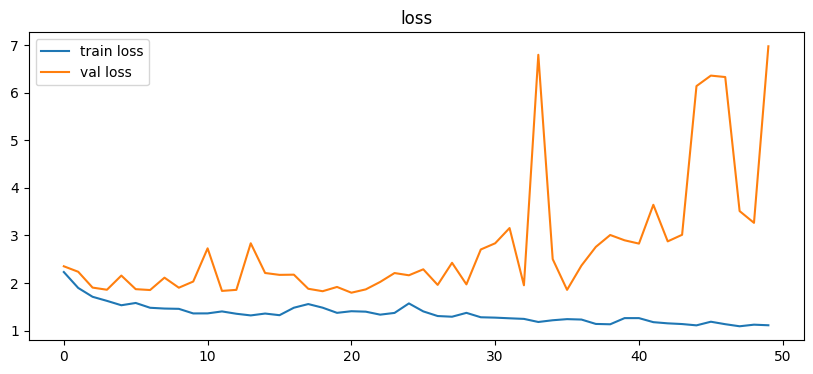

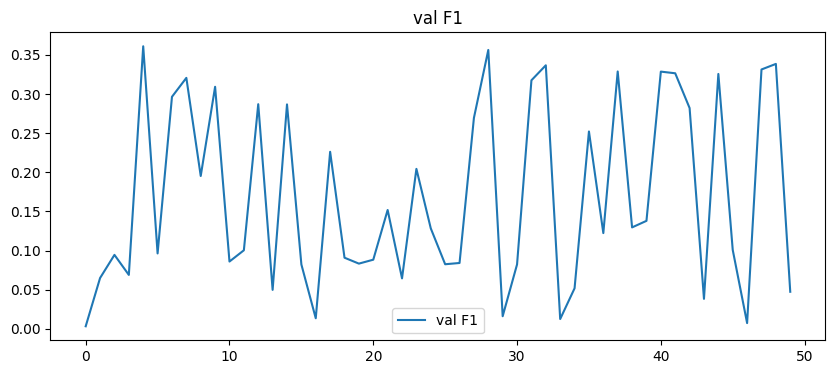

In [105]:
fullloop(model8, train_iterator, val_iterator, optimizer, criterion, num_epochs=50)

# another one

In [139]:
class MLP9w2v(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(weights, dtype=torch.float32, device=DEVICE),
            freeze=False,
            padding_idx=0
        )

        self.emb2h1 = nn.Linear(embedding_dim, 60).to(DEVICE)  # 128
        self.batchnorm1 = nn.BatchNorm1d(60).to(DEVICE)
        self.act1 = nn.ReLU().to(DEVICE)
        self.dropout1 = nn.Dropout(p=0.2).to(DEVICE)

        self.emb2h2 = nn.Linear(60, 30).to(DEVICE)  # 128 -> 64
        self.batchnorm2 = nn.BatchNorm1d(30).to(DEVICE)
        self.act2 = nn.Tanh() # ну вдруг
        #self.dropout2 = nn.Dropout(p=0.2).to(DEVICE)

        self.h2out = nn.Linear(30, 10).to(DEVICE)   # 64 -> 10

    def forward(self, text):
        embedded = self.embedding(text).to(DEVICE)

        mean_emb = torch.mean(embedded, dim=1).to(DEVICE)

        hidden1 = self.emb2h1(mean_emb).to(DEVICE)
        hidden1 = self.batchnorm1(hidden1).to(DEVICE)
        hidden1 = self.act1(hidden1).to(DEVICE)
        hidden1 = self.dropout1(hidden1).to(DEVICE)

        hidden2 = self.emb2h2(hidden1).to(DEVICE)

        hidden2 = self.batchnorm2(hidden2).to(DEVICE)
        hidden2 = self.act2(hidden2).to(DEVICE)
        #hidden2 = self.dropout2(hidden2).to(DEVICE)

        out = self.h2out(hidden2).to(DEVICE)  # возвращаем одно число для каждого семпла

        return out

In [142]:
model9 = MLP9w2v(len(word2id), 100)
optimizer = optim.Adadelta(model9.parameters(), lr=0.005, weight_decay=1e-3) # weight_decay=1e-5
criterion = nn.CrossEntropyLoss(weight=yweights.to(DEVICE))
#schedulerplateau = ReduceLROnPlateau(optimizer, 'min')


model9 = model9.to(DEVICE)
criterion = criterion.to(DEVICE)

training...

validating...
epoch 0, train loss = 2.272520141168074, val loss = 2.305384302139282, val f1 score = 0.051424064649578556
training...

validating...
training...

validating...
epoch 2, train loss = 2.1517919274893673, val loss = 2.2190489292144777, val f1 score = 0.054854643987929656
training...

validating...
training...

validating...
epoch 4, train loss = 2.0999486527659674, val loss = 2.172563982009888, val f1 score = 0.06228454038364726
training...

validating...
training...

validating...
epoch 6, train loss = 2.039947534149343, val loss = 2.1341609001159667, val f1 score = 0.07013425351172002
training...

validating...
training...

validating...
epoch 8, train loss = 1.990717958320271, val loss = 2.1050426959991455, val f1 score = 0.0787314647098344
training...

validating...
training...

validating...
epoch 10, train loss = 1.9491890316659755, val loss = 2.096299982070923, val f1 score = 0.0726139997176392
training...

validating...
training...

validating...
epoch 

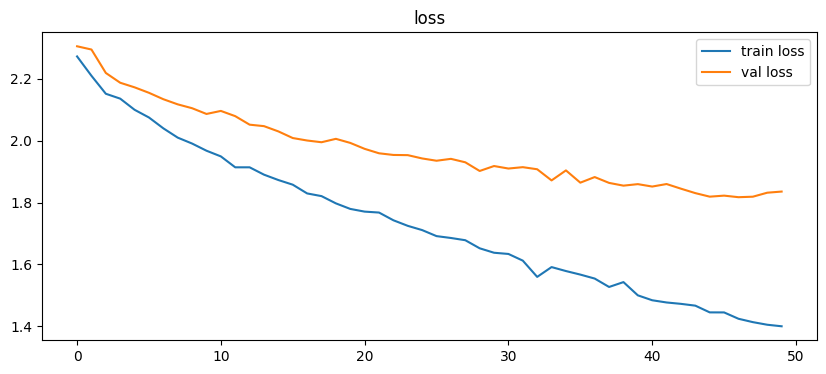

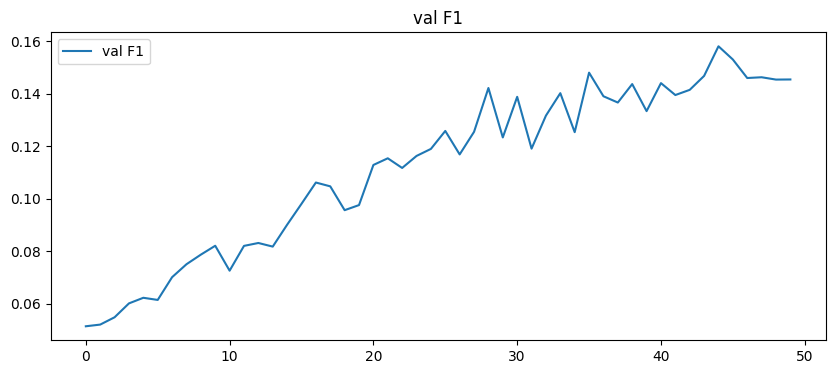

In [143]:
fullloop(model9, train_iterator, val_iterator, optimizer, criterion, num_epochs=50)

### блин вот эта модель на удивление стабильная

In [130]:
DEVICE

device(type='cuda')

## другая

In [145]:
class MLP10w2v(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(weights, dtype=torch.float32, device=DEVICE),
            freeze=False,
            padding_idx=0
        )

        self.emb2h1 = nn.Linear(embedding_dim, 60).to(DEVICE)  # 128
        self.batchnorm1 = nn.BatchNorm1d(60).to(DEVICE)
        self.act1 = nn.ReLU().to(DEVICE)
        self.dropout1 = nn.Dropout(p=0.2).to(DEVICE)

        self.emb2h2 = nn.Linear(60, 30).to(DEVICE)  # 128 -> 64
        self.batchnorm2 = nn.BatchNorm1d(30).to(DEVICE)
        self.act2 = nn.LeakyReLU()
        #self.dropout2 = nn.Dropout(p=0.2).to(DEVICE)

        self.h2out = nn.Linear(30, 10).to(DEVICE)   # 64 -> 10

    def forward(self, text):
        embedded = self.embedding(text).to(DEVICE)

        mean_emb = torch.mean(embedded, dim=1).to(DEVICE)

        hidden1 = self.emb2h1(mean_emb).to(DEVICE)
        hidden1 = self.batchnorm1(hidden1).to(DEVICE)
        hidden1 = self.act1(hidden1).to(DEVICE)
        hidden1 = self.dropout1(hidden1).to(DEVICE)

        hidden2 = self.emb2h2(hidden1).to(DEVICE)

        hidden2 = self.batchnorm2(hidden2).to(DEVICE)
        hidden2 = self.act2(hidden2).to(DEVICE)
        #hidden2 = self.dropout2(hidden2).to(DEVICE)

        out = self.h2out(hidden2).to(DEVICE)  # возвращаем одно число для каждого семпла

        return out

In [148]:
model10 = MLP10w2v(len(word2id), 100)
optimizer = optim.Adadelta(model10.parameters(), lr=0.006, weight_decay=1e-3) # weight_decay=1e-5
criterion = nn.CrossEntropyLoss(weight=yweights.to(DEVICE))
#schedulerplateau = ReduceLROnPlateau(optimizer, 'min')


model10 = model10.to(DEVICE)
criterion = criterion.to(DEVICE)

training...

validating...
epoch 0, train loss = 2.2926725040782583, val loss = 2.3075900077819824, val f1 score = 0.0012346372046257274
training...

validating...
training...

validating...
epoch 2, train loss = 2.2122276804663916, val loss = 2.2515894412994384, val f1 score = 0.3267917108322361
training...

validating...
training...

validating...
epoch 4, train loss = 2.151885845444419, val loss = 2.213065814971924, val f1 score = 0.31999991878556117
training...

validating...
training...

validating...
epoch 6, train loss = 2.1042562939903955, val loss = 2.181069755554199, val f1 score = 0.3073588025038434
training...

validating...
training...

validating...
epoch 8, train loss = 2.0619536990469154, val loss = 2.166440153121948, val f1 score = 0.28426199210074826
training...

validating...
training...

validating...
epoch 10, train loss = 1.9917958785187115, val loss = 2.1404009819030763, val f1 score = 0.28394588366534135
training...

validating...
training...

validating...
epoc

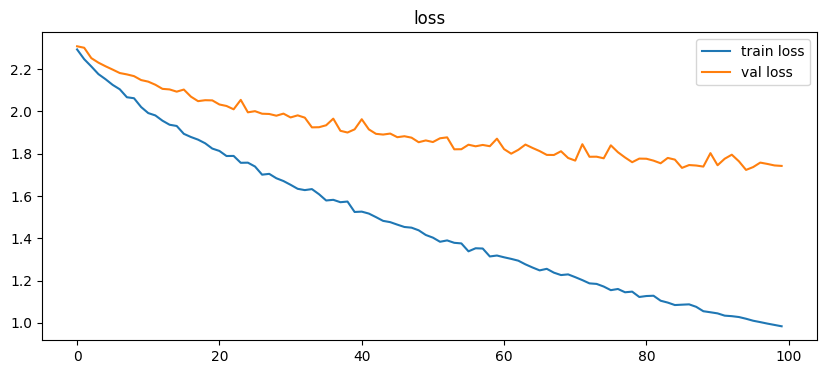

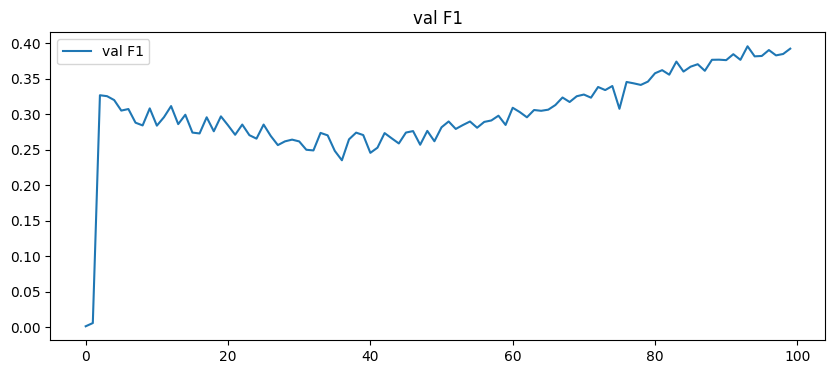

In [149]:
fullloop(model10, train_iterator, val_iterator, optimizer, criterion, num_epochs=100)

### не идеально, конечно, но очень даже ничего как будто!!

In [155]:
model11 = MLP10w2v(len(word2id), 100)
optimizer = optim.Adadelta(model11.parameters(), lr=0.006, weight_decay=1e-2) # weight_decay=1e-5
criterion = nn.CrossEntropyLoss(weight=yweights.to(DEVICE))
#schedulerplateau = ReduceLROnPlateau(optimizer, 'min')


model11 = model11.to(DEVICE)
criterion = criterion.to(DEVICE)

training...

validating...
epoch 0, train loss = 2.291669412092729, val loss = 2.3078207969665527, val f1 score = 0.3149153128997774
training...

validating...
training...

validating...
epoch 2, train loss = 2.2272332473234697, val loss = 2.454739809036255, val f1 score = 0.31657882039709534
training...

validating...
training...

validating...
epoch 4, train loss = 2.1732737747105686, val loss = 2.4311969757080076, val f1 score = 0.3182787030897184
training...

validating...
training...

validating...
epoch 6, train loss = 2.127315185286782, val loss = 2.3870627880096436, val f1 score = 0.3217124203056773
training...

validating...
training...

validating...
epoch 8, train loss = 2.0855614082379774, val loss = 2.3629590034484864, val f1 score = 0.32512021994887746
training...

validating...
training...

validating...
epoch 10, train loss = 2.044079531322826, val loss = 2.320624017715454, val f1 score = 0.3284527562772388
training...

validating...
training...

validating...
epoch 12,

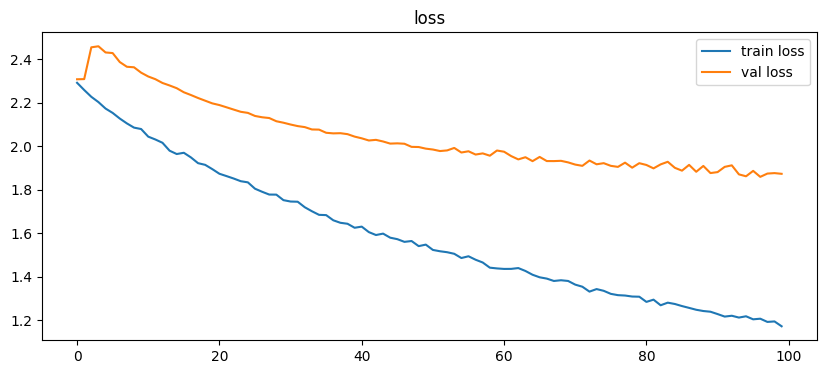

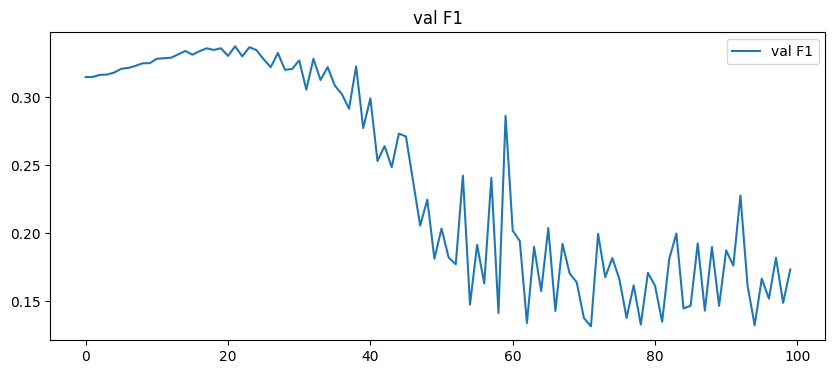

In [156]:
fullloop(model11, train_iterator, val_iterator, optimizer, criterion, num_epochs=100)

## нет, это что-то с чем-то

In [157]:
model12 = MLP10w2v(len(word2id), 100)
optimizer = optim.AdamW(model12.parameters(), lr=0.006, weight_decay=1e-3) # weight_decay=1e-5
criterion = nn.CrossEntropyLoss(weight=yweights.to(DEVICE))
#schedulerplateau = ReduceLROnPlateau(optimizer, 'min')


model12 = model12.to(DEVICE)
criterion = criterion.to(DEVICE)

In [158]:
fullloop(model12, train_iterator, val_iterator, optimizer, criterion, num_epochs=100)

training...

validating...
epoch 0, train loss = 2.135824520479549, val loss = 2.482912302017212, val f1 score = 0.017335692239273198
training...

validating...
training...

validating...
epoch 2, train loss = 1.1258018301291899, val loss = 13.18239459991455, val f1 score = 0.0005631284188889944
training...

validating...
training...

validating...
epoch 4, train loss = 0.6707501072775234, val loss = 14.005479621887208, val f1 score = 0.02237290301827294
training...

validating...
training...

validating...
epoch 6, train loss = 0.4205879047513008, val loss = 12.91197395324707, val f1 score = 0.006614413268963682
training...

validating...
training...

validating...
epoch 8, train loss = 0.3628736338154836, val loss = 5.328625679016113, val f1 score = 0.33095751440475446
training...

validating...
training...

validating...
epoch 10, train loss = 0.31118708645755594, val loss = 5.733423805236816, val f1 score = 0.018629102307894684
training...

validating...
training...

validating...


KeyboardInterrupt: 

epoch 48, train loss = 0.07400519168004394, val loss = 3.444092130661011, val f1 score = 0.5057180408598291 самый высокий на данный момент f1, но ооочень сильное переобучение, не стала до конца обучать её

In [165]:
model13 = MLP10w2v(len(word2id), 100)
optimizer = optim.AdamW(model13.parameters(), lr=0.005, weight_decay=0.0001) # weight_decay=1e-5
criterion = nn.CrossEntropyLoss(weight=yweights.to(DEVICE))
#schedulerplateau = ReduceLROnPlateau(optimizer, 'min')


model13 = model13.to(DEVICE)
criterion = criterion.to(DEVICE)

In [166]:
fullloop(model13, train_iterator, val_iterator, optimizer, criterion, num_epochs=100)

training...

validating...
epoch 0, train loss = 2.134319473396648, val loss = 2.3750492095947267, val f1 score = 0.0620058179406636
training...

validating...
training...

validating...
epoch 2, train loss = 1.0653027079322122, val loss = 5.376770305633545, val f1 score = 0.05389926656032906
training...

validating...
training...

validating...
epoch 4, train loss = 0.5646488619121638, val loss = 13.05925235748291, val f1 score = 0.00816921100613752
training...

validating...
training...

validating...
epoch 6, train loss = 0.45075854523615405, val loss = 12.374390029907227, val f1 score = 0.010627275682914512
training...

validating...
training...

validating...
epoch 8, train loss = 0.38453982025384903, val loss = 2.8194132328033445, val f1 score = 0.027764294042346926
training...

validating...
training...

validating...
epoch 10, train loss = 0.2710561044514179, val loss = 5.304612064361573, val f1 score = 0.09972893570181171
training...

validating...
training...

validating...
e

KeyboardInterrupt: 

In [171]:
from torch.optim.lr_scheduler import PolynomialLR

In [172]:
model14 = MLP10w2v(len(word2id), 100)
optimizer = optim.Adamax(model14.parameters(), lr=0.006, weight_decay=1e-2) # weight_decay=1e-5
criterion = nn.CrossEntropyLoss(weight=yweights.to(DEVICE))
schedulerpoly = PolynomialLR(optimizer, total_iters=4, power=1.0)
#schedulerplateau = ReduceLROnPlateau(optimizer, 'min')


model14 = model14.to(DEVICE)
criterion = criterion.to(DEVICE)

In [173]:
fullloop(model14, train_iterator, val_iterator, optimizer, criterion, num_epochs=100, scheduler=schedulerpoly)

training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 0, LR: 0.0025181334257125855
epoch 0, train loss = 2.2179106907411055, val loss = 2.3212443828582763, val f1 score = 3.934704073670667e-05
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 2, LR: 0.0029839897513389588
epoch 2, train loss = 1.8888273645531048, val loss = 2.010673499107361, val f1 score = 0.315683345122609
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 4, LR: 0.0031007148385047913
epoch 4, train loss = 1.7043088511987166, val loss = 1.9328567743301392, val f1 score = 0.15642412856033613
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 6, LR: 0.002520129919052124
epoch 6, train loss = 1.480539695783095, val loss = 2.319913387298584, val f1 score = 0.060616769917878816
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 8, LR: 0.0
epoch 8, train loss = 1.3361768939278342, val loss = 4.8770976066589355, val f1 score = 0.0022960672255835537
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 10, LR: 0.0
epoch 10, train loss = 1.2742575136097996, val loss = 8.476149368286134, val f1 score = 0.0031172235563247087
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 12, LR: 0.002002529311180115
epoch 12, train loss = 1.2107814225283535, val loss = 2.6649804592132567, val f1 score = 0.059927244509806146
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 14, LR: 0.0008934381723403928
epoch 14, train loss = 1.072497934103012, val loss = 3.4043745517730715, val f1 score = 0.018797031895051327
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 16, LR: 0.000755008149147034
epoch 16, train loss = 1.0031432130120017, val loss = 3.4966612339019774, val f1 score = 0.027671791544379886
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 18, LR: 0.0
epoch 18, train loss = 0.9199592769145966, val loss = 5.639512252807617, val f1 score = 0.0075570046641368575
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 20, LR: 0.0
epoch 20, train loss = 0.9634816633029417, val loss = 14.16147575378418, val f1 score = 0.0023110969944544948
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...


KeyboardInterrupt: 

In [174]:
model15 = MLP10w2v(len(word2id), 100)
optimizer = optim.Adadelta(model15.parameters(), lr=0.006, weight_decay=1e-3) # weight_decay=1e-5
criterion = nn.CrossEntropyLoss(weight=yweights.to(DEVICE))
schedulerpoly = PolynomialLR(optimizer, total_iters=5, power=1.0)
#schedulerplateau = ReduceLROnPlateau(optimizer, 'min')


model15 = model15.to(DEVICE)
criterion = criterion.to(DEVICE)

training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 0, LR: 0.003222647266387939
epoch 0, train loss = 2.288853791627017, val loss = 2.314460611343384, val f1 score = 0.051424064649578556
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 2, LR: 0.0032669178199768068
epoch 2, train loss = 2.237168935212222, val loss = 2.277568483352661, val f1 score = 0.11103068371686299
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 4, LR: 0.003286953678131104
epoch 4, train loss = 2.2021852514960547, val loss = 2.260871934890747, val f1 score = 0.17337589086204658
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 6, LR: 0.00330705717086792
epoch 6, train loss = 2.1781728619878944, val loss = 2.2441190242767335, val f1 score = 0.13338910994512057
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 8, LR: 0.003324030876159668
epoch 8, train loss = 2.1393429149280894, val loss = 2.2299742698669434, val f1 score = 0.10452118503230991
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 10, LR: 0.0033439130401611322
epoch 10, train loss = 2.1051434711976484, val loss = 2.213405799865723, val f1 score = 0.16293835747130886
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 12, LR: 0.0033624406814575193
epoch 12, train loss = 2.105102828957818, val loss = 2.1979660987854004, val f1 score = 0.14656131858839094
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 14, LR: 0.0033742886924743656
epoch 14, train loss = 2.075840776616877, val loss = 2.188092756271362, val f1 score = 0.1317855621564255
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 16, LR: 0.0033955583953857427
epoch 16, train loss = 2.034757039763711, val loss = 2.1703680038452147, val f1 score = 0.1544508214209059
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 18, LR: 0.003415956687927246
epoch 18, train loss = 2.018593032251705, val loss = 2.153369426727295, val f1 score = 0.1830846042764815
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 20, LR: 0.0034314289283752446
epoch 20, train loss = 1.9972886361859061, val loss = 2.14047589302063, val f1 score = 0.1813198624137429
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 22, LR: 0.003442556819915771
epoch 22, train loss = 1.9745794074101881, val loss = 2.1312026500701906, val f1 score = 0.15724998182985253
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 24, LR: 0.0034574904441833495
epoch 24, train loss = 1.9723988067020068, val loss = 2.118757963180542, val f1 score = 0.18886597642159816
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 26, LR: 0.0034580510330200196
epoch 26, train loss = 1.9319978762756695, val loss = 2.1182908058166503, val f1 score = 0.15352202374703156
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 28, LR: 0.0034807667541503903
epoch 28, train loss = 1.9228815707293423, val loss = 2.099361038208008, val f1 score = 0.1874046538573813
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 30, LR: 0.0034900706291198734
epoch 30, train loss = 1.8963292159817435, val loss = 2.0916078090667725, val f1 score = 0.19280403908404944
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 32, LR: 0.003512211570739746
epoch 32, train loss = 1.8711301684379578, val loss = 2.073157024383545, val f1 score = 0.24184524081824746
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 34, LR: 0.0035129736328125003
epoch 34, train loss = 1.8590915446931666, val loss = 2.07252197265625, val f1 score = 0.2379242764178409
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 36, LR: 0.003533681316375733
epoch 36, train loss = 1.8585830385034734, val loss = 2.0552655696868896, val f1 score = 0.24345393163103807
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 38, LR: 0.003551261701583863
epoch 38, train loss = 1.8607495860619978, val loss = 2.0406152486801146, val f1 score = 0.2550628966018905
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 40, LR: 0.0035356625461578375
epoch 40, train loss = 1.8101395233110948, val loss = 2.053614544868469, val f1 score = 0.23357729509000563
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 42, LR: 0.0035610972118377683
epoch 42, train loss = 1.8079290227456526, val loss = 2.032418990135193, val f1 score = 0.26954665727448396
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 44, LR: 0.003568510980606079
epoch 44, train loss = 1.788757091218775, val loss = 2.026240849494934, val f1 score = 0.24206049656990206
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 46, LR: 0.0036020381355285646
epoch 46, train loss = 1.7832845639098773, val loss = 1.9983015537261963, val f1 score = 0.29196569205369755
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 48, LR: 0.003576233510971069
epoch 48, train loss = 1.750563458962874, val loss = 2.019805407524109, val f1 score = 0.24922223710727448
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 50, LR: 0.003617531147003174
epoch 50, train loss = 1.7591613964600996, val loss = 1.9853907108306885, val f1 score = 0.3018520246532208
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 52, LR: 0.0036107161045074465
epoch 52, train loss = 1.7296623614701359, val loss = 1.9910699129104614, val f1 score = 0.28805558081322574
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 54, LR: 0.0036274245643615724
epoch 54, train loss = 1.7270574542609127, val loss = 1.9771461963653565, val f1 score = 0.31048281245791076
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 56, LR: 0.003617590713500977
epoch 56, train loss = 1.6953763365745544, val loss = 1.9853410720825195, val f1 score = 0.28986575263761544
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 58, LR: 0.00364488284111023
epoch 58, train loss = 1.6994446705688129, val loss = 1.962597632408142, val f1 score = 0.3082338386228536
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 60, LR: 0.0035895670795440676
epoch 60, train loss = 1.6696155613118953, val loss = 2.0086941003799437, val f1 score = 0.235323801700957
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 62, LR: 0.003637315721511841
epoch 62, train loss = 1.6455102291974155, val loss = 1.9689035654067992, val f1 score = 0.2847241245906257
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 64, LR: 0.003663541088104248
epoch 64, train loss = 1.647288528355685, val loss = 1.94704909324646, val f1 score = 0.3153542757224646
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 66, LR: 0.0036753910160064697
epoch 66, train loss = 1.6386983421715824, val loss = 1.9371741533279419, val f1 score = 0.3071922524227399
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 68, LR: 0.0036587726783752442
epoch 68, train loss = 1.622845086184415, val loss = 1.9510227680206298, val f1 score = 0.29596103313287603
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 70, LR: 0.003681681175231934
epoch 70, train loss = 1.6086878641085192, val loss = 1.9319323539733886, val f1 score = 0.3128232803726752
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 72, LR: 0.003695971097946167
epoch 72, train loss = 1.5926867669278926, val loss = 1.9200240850448609, val f1 score = 0.3128477562624471
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 74, LR: 0.003699814796447754
epoch 74, train loss = 1.5709947835315357, val loss = 1.916821002960205, val f1 score = 0.31473007281185383
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 76, LR: 0.0036991829681396484
epoch 76, train loss = 1.5488892874934457, val loss = 1.917347526550293, val f1 score = 0.3098144637082825
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 78, LR: 0.0037306686687469484
epoch 78, train loss = 1.5588978014209054, val loss = 1.8911094427108766, val f1 score = 0.33445232648161877
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 80, LR: 0.003717138376235962
epoch 80, train loss = 1.5434436906467786, val loss = 1.9023846864700318, val f1 score = 0.32713799852222614
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 82, LR: 0.0037241928577423098
epoch 82, train loss = 1.5237138460982929, val loss = 1.8965059518814087, val f1 score = 0.31223287332852684
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 84, LR: 0.0037248408222198487
epoch 84, train loss = 1.5019121982834556, val loss = 1.8959659814834595, val f1 score = 0.3388936234290115
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 86, LR: 0.0037290936756134035
epoch 86, train loss = 1.4998895823955536, val loss = 1.8924219369888307, val f1 score = 0.3270791943321806
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 88, LR: 0.0037432750511169435
epoch 88, train loss = 1.475593474778262, val loss = 1.880604124069214, val f1 score = 0.34193193652679416
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 90, LR: 0.0037426351261138917
epoch 90, train loss = 1.4611658914522692, val loss = 1.8811373949050902, val f1 score = 0.3256042430420929
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 92, LR: 0.003734190130233765
epoch 92, train loss = 1.4328921735286713, val loss = 1.8881748914718628, val f1 score = 0.3279314990647244
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 94, LR: 0.003732240056991577
epoch 94, train loss = 1.4499074220657349, val loss = 1.889799952507019, val f1 score = 0.3538167686747604
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 96, LR: 0.003702388114929199
epoch 96, train loss = 1.4277130148627541, val loss = 1.914676570892334, val f1 score = 0.33851501836370734
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch 98, LR: 0.003753563861846924
epoch 98, train loss = 1.4130639325488696, val loss = 1.8720301151275636, val f1 score = 0.33274503362952085
training...

validating...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


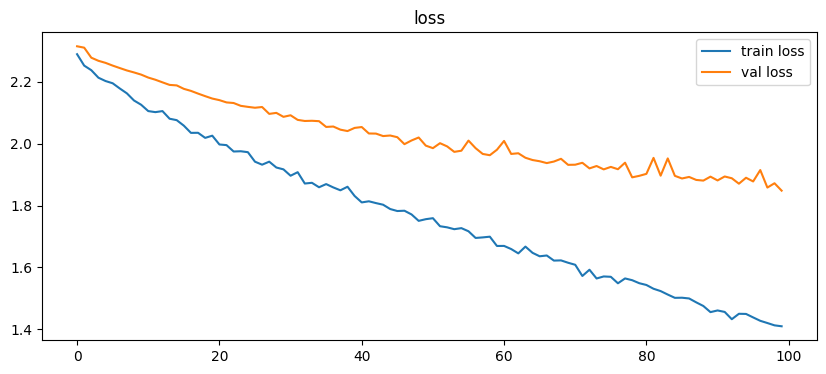

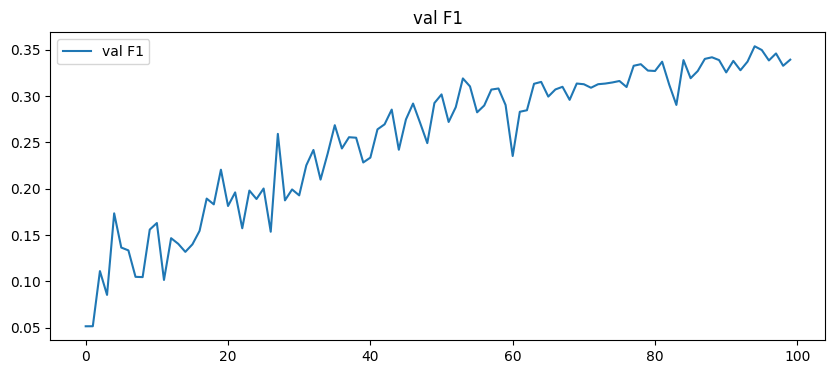

In [175]:
fullloop(model15, train_iterator, val_iterator, optimizer, criterion, num_epochs=100, scheduler=schedulerpoly)